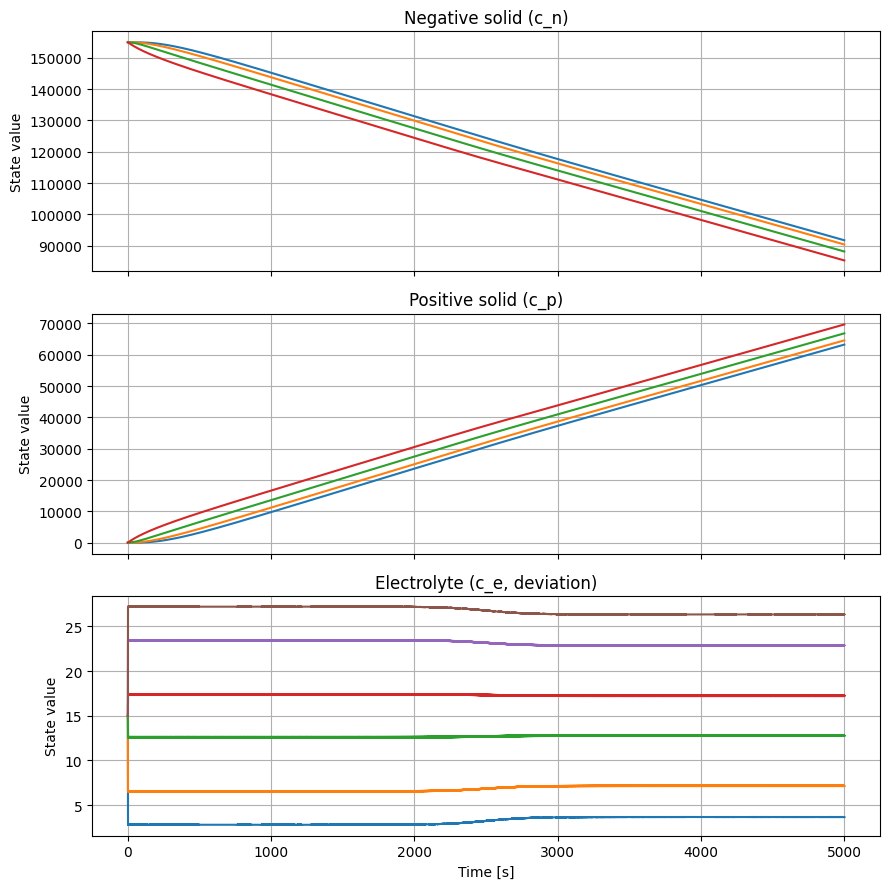

=== State Extrema Summary ===
cn      : min= 8.530e+04, max= 1.550e+05
cp      : min= 0.000e+00, max= 6.970e+04
ce      : min= 2.788e+00, max= 2.721e+01


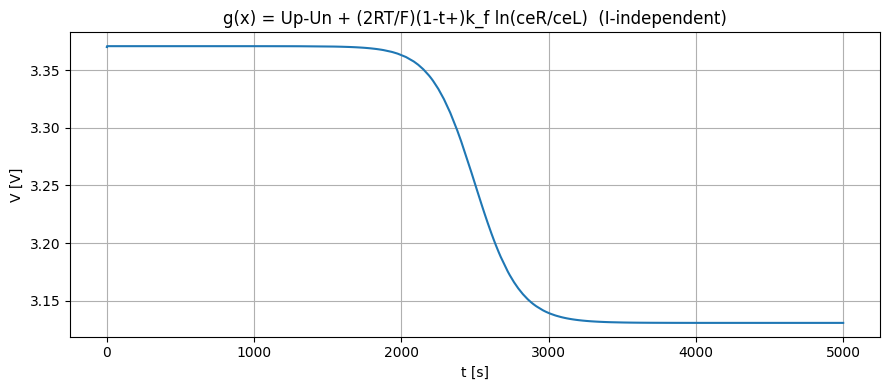

In [98]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import control as ct
from scipy.linalg import block_diag
from IPython.display import display


# =========================================================
# Configuration
# =========================================================
# Current sign convention for this file:
# I > 0 ==> DISCHARGE (electrons leave negative terminal)
I_POSITIVE_IS_DISCHARGE: bool = True


# --------------------------
# Index map (global)
# --------------------------
# x = [c_n1,c_n2,c_n3,c_n4, c_p1,c_p2,c_p3,c_p4, ce1,ce2,ce3,ce4,ce5,ce6]
IDX = {
    "cn": slice(0,4),
    "cp": slice(4,8),
    "ce": slice(8,14),

    # "Surface" choices used by the voltage layer (you can change these later)
    "cn_surf": 2,    # cn3 as neg "surface"
    "cp_surf": 4,    # absolute index 4 (= local cp1) as pos "surface"
    "ce_left": 8,    # ce1  (negative-collector end)
    "ce_right": 13,  # ce6  (positive-collector end)
}

# --------------------------
# Physical constants
# --------------------------
@dataclass
class PhysParams:
    R: float = 8.314462618    # J/(mol·K)
    F: float = 96485.33212    # C/mol
    T: float = 298.15         # K
    t_plus: float = 0.38
    kf: float = 1.0           # multiplier on the ln term
    Re: float = 0.0           # series ohmic, if used
    Rf: float = 0.0           # film (aging), if used
    csn_max: float = 3.1e4    # [mol/m^3]
    csp_max: float = 5.1e4    # [mol/m^3]

PP = PhysParams()
R_GAS = PP.R

# --------------------------
# Solid diffusion (4×4)
# --------------------------
def build_An(Dn: float, Rn: float) -> np.ndarray:
    s = Dn/(Rn**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*s,  24*s
    A[1,0], A[1,1], A[1,2] =  16*s, -40*s, 24*s
    A[2,1], A[2,2], A[2,3] =  16*s, -40*s, 24*s
    A[3,2], A[3,3] =  16*s, -16*s
    return A

def build_Bn(Dn: float, Rn: float, a: float, A: float, L_n: float, *, discharge_positive: bool = True) -> np.ndarray:
    """Input column for negative solid (last state is surface).
    If discharge_positive=True (our default), positive current causes *deintercalation* at the negative electrode, so the
    surface source term is negative. This flips the sign compared to a charge-positive convention.
    """
    sign = -1.0 if discharge_positive else +1.0
    b = np.zeros((4,1))
    b[-1,0] = sign * (6.0/Rn) * (1.0/(PP.F * a * A * L_n))
    return b


def build_Ap(Dp: float, Rp: float) -> np.ndarray:
    s = Dp/(Rp**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*s, 24*s
    A[1,0], A[1,1], A[1,2] = 16*s, -40*s, 24*s
    A[2,1], A[2,2], A[2,3] = 16*s, -40*s, 24*s
    A[3,2], A[3,3] = 16*s, -16*s
    return A



def build_Bp(Dp: float, Rp: float, a: float, A: float, L_p: float, *, discharge_positive: bool = True) -> np.ndarray:
    """Input column for positive solid (last state is surface).
    If discharge_positive=True, positive current causes *intercalation* at the positive electrode, so the surface term is positive.
    """
    sign = +1.0 if discharge_positive else -1.0
    b = np.zeros((4,1))
    b[-1,0] = sign * (6.0/Rp) * (1.0/(PP.F * a * A * L_p))
    return b



# --------------------------
# Electrolyte diffusion (6×6) — dissipative sign (negative diagonal)
# --------------------------


def build_Ae(D_e: float, eps: float, Ln: float, Lsep: float, Lp: float) -> np.ndarray:
    K = D_e/eps
    Ae = np.zeros((6,6))
    w_in = lambda L: K * 4.0 / (L**2)
    w_intf = lambda La, Lb: K * 16.0 / ((La + Lb)**2)


    w11 = w_in(Ln)
    w12 = w_intf(Ln, Lsep)
    w23 = w_in(Lsep)
    w34 = w_intf(Lsep, Lp)
    w45 = w_in(Lp)


    # ce1
    Ae[0,0] = -(w11); Ae[0,1] = +(w11)
    # ce2
    Ae[1,0] = +(w11); Ae[1,1] = -(w11 + w12); Ae[1,2] = +(w12)
    # ce3
    Ae[2,1] = +(w12); Ae[2,2] = -(w12 + w23); Ae[2,3] = +(w23)
    # ce4
    Ae[3,2] = +(w23); Ae[3,3] = -(w23 + w34); Ae[3,4] = +(w34)
    # ce5
    Ae[4,3] = +(w34); Ae[4,4] = -(w34 + w45); Ae[4,5] = +(w45)
    # ce6
    Ae[5,4] = +(w45); Ae[5,5] = -(w45)
    return Ae


def build_Be(Ln: float, Lp: float, eps1: float, eps3: float, A: float, t_plus: float, *, discharge_positive: bool = True) -> np.ndarray:
    """
    Distributed source/sink in the electrode regions only (separator zero).
    If discharge_positive=True, positive current *removes* Li+ from the negative electrode electrolyte (net sink, sign -)
    and *adds* Li+ to the positive electrode electrolyte (net source, sign +).
    """
    b = np.zeros((6,1))
    sign_left = -1.0 if discharge_positive else +1.0 # N-region (near negative current collector)
    sign_right = +1.0 if discharge_positive else -1.0 # P-region (near positive current collector)


    s1 = sign_left * (1.0 - t_plus) / (PP.F * A * Ln * eps1)
    s3 = sign_right * (1.0 - t_plus) / (PP.F * A * Lp * eps3)


    b[0,0] = s1; b[1,0] = s1
    b[4,0] = s3; b[5,0] = s3
    return b

# --------------------------
# System assembly
# --------------------------


def assemble_system(params: dict, *, discharge_positive: bool = I_POSITIVE_IS_DISCHARGE):
    # geometry & transport
    Dn = params.get("Dn", 1e-14); Rn = params.get("Rn", 5e-6)
    Dp = params.get("Dp", 1e-14); Rp = params.get("Rp", 5e-6)
    L1 = params.get("L1", 25e-6); L2 = params.get("L2", 20e-6); L3 = params.get("L3", 25e-6)
    a_s_n = params.get("a_s_n", 1.0e6); a_s_p = params.get("a_s_p", 1.0e6)


    # area
    electrode_area = params.get("A", params.get("A_e", 1.0))


    # electrolyte
    D_e = params.get("D_e", params.get("De", 7.23e-10))
    eps = params.get("eps", 0.30)


    # build blocks with *discharge-positive* sign convention
    An = build_An(Dn, Rn)
    Ap = build_Ap(Dp, Rp)
    Bn = build_Bn(Dn, Rn, a_s_n, electrode_area, L1, discharge_positive=discharge_positive)
    Bp = build_Bp(Dp, Rp, a_s_p, electrode_area, L3, discharge_positive=discharge_positive)
    Ae = build_Ae(D_e, eps, L1, L2, L3)
    Be = build_Be(L1, L3, eps, eps, electrode_area, PP.t_plus, discharge_positive=discharge_positive)


    # global
    Aglob = block_diag(An, Ap, Ae)
    Bglob = np.vstack([Bn, Bp, Be])


    # names
    state_names = [f'cn{i}' for i in range(1,5)] + [f'cp{i}' for i in range(1,5)] + [f'ce{i}' for i in range(1,7)]


    S = ct.ss(Aglob, Bglob, np.eye(Aglob.shape[0]), np.zeros((Aglob.shape[0],1)))
    return S, Aglob, Bglob, (An, Ap, Ae, Bn, Bp, Be), state_names

# --------------------------
# Helpers: ICs, display
# --------------------------


def make_x0(theta_n0=0.2, theta_p0=0.9, ce0=0.0, pp: PhysParams = PP):
    """Build initial state.
    NOTE: ce0 is a *deviation* if you use VParams(ce_is_deviation=True). Use ce0=0.0 for nominal electrolyte.
    """
    x0 = np.zeros(14)
    x0[IDX["cn"]] = theta_n0 * pp.csn_max
    x0[IDX["cp"]] = theta_p0 * pp.csp_max
    x0[IDX["ce"]] = ce0
    return x0

def show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B, state_names):
    def df(M, rnames, cnames): return pd.DataFrame(M, index=rnames, columns=cnames)
    cn_names = [f'cn{i}' for i in range(1, An.shape[0]+1)]
    cp_names = [f'cp{i}' for i in range(1, Ap.shape[0]+1)]
    ce_names = [f'ce{i}' for i in range(1, Ae.shape[0]+1)]
    display(df(An, cn_names, cn_names)); display(df(Bn, cn_names, ['u']))
    display(df(Ap, cp_names, cp_names)); display(df(Bp, cp_names, ['u']))
    display(df(Ae, ce_names, ce_names)); display(df(Be, ce_names, ['u']))
    display(df(A, state_names, state_names)); display(df(B, state_names, ['u']))
    print("A shape:", A.shape, " B shape:", B.shape)


def plot_states_grouped(t: np.ndarray, X_TN: np.ndarray):
    groups = {
        "Negative Electrode": ["cn"],
        "Positive Electrode": ["cp"],
        "Electrolyte": ["ce"]
    }
    fig, axs = plt.subplots(3, 1, figsize=(9, 9), sharex=True)
    # cn
    axs[0].plot(t, X_TN[:, IDX["cn"]]); axs[0].set_title("Negative solid (c_n)")
    axs[1].plot(t, X_TN[:, IDX["cp"]]); axs[1].set_title("Positive solid (c_p)")
    axs[2].plot(t, X_TN[:, IDX["ce"]]); axs[2].set_title("Electrolyte (c_e, deviation)")
    for ax in axs: ax.grid(True); ax.set_ylabel("State value")
    axs[-1].set_xlabel("Time [s]"); plt.tight_layout(); plt.show()

def report_extrema_matrix(X_TN: np.ndarray):
    print("=== State Extrema Summary ===")
    for name in ["cn","cp","ce"]:
        arr = X_TN[:, IDX[name]]
        print(f"{name:<8s}: min={arr.min(): .3e}, max={arr.max(): .3e}")




# --------------------------
# OCVs & Voltage params
# --------------------------
def ocp_p_safe(xp: np.ndarray) -> np.ndarray:
    xp = np.clip(xp, 1e-6, 1-1e-6)
    return 4.15 - 0.12*np.tanh((xp - 0.60)/0.08)

def ocp_n_safe(xn: np.ndarray) -> np.ndarray:
    xn = np.clip(xn, 1e-6, 1-1e-6)
    return 0.10 + 0.80*(1/(1 + np.exp(-(xn-0.50)/0.04)))

# def safe_log_ratio(a, b, eps=1e-12):
#     a = np.maximum(a, eps); b = np.maximum(b, eps)
#     return np.log(a/b)

# def eta_block(u: float, kind="linear", Rct=0.0, I0=10.0, T=PP.T, alpha=0.5):
#     if kind == "none":   return 0.0
#     if kind == "linear": return Rct * u
#     if kind == "bv":     return (2*R_GAS*T/(alpha*PP.F)) * np.arcsinh(u/(2*I0))
#     raise ValueError("eta kind unknown")


@dataclass
class VParams:
    A: float = 1.0
    L_n: float = 25e-6
    L_p: float = 25e-6
    a_s_n: float = 1.0e6
    a_s_p: float = 1.0e6
    k_n: float = 2.0e-11
    k_p: float = 2.0e-11
    cs_n_max: float = 3.1e4
    cs_p_max: float = 5.1e4
    ce0: float = 1000.0
    t_plus: float = PP.t_plus
    k_f: float = 1.0
    Re: float = 0.0
    Rf: float = 0.0
    R_ohm: float = 0.0
    T: float = 298.15
    ce_is_deviation: bool = True

# def _extract_surface_and_ce(X_TN: np.ndarray, vp: VParams):
#     xp = np.clip(X_TN[:, IDX["cp_surf"]], 1e-9, 1-1e-9) / vp.cs_p_max
#     xn = np.clip(X_TN[:, IDX["cn_surf"]], 1e-9, 1-1e-9) / vp.cs_n_max
#     ceL_raw = X_TN[:, IDX["ce_left"]]
#     ceR_raw = X_TN[:, IDX["ce_right"]]
#     ceL = (vp.ce0 + ceL_raw) if vp.ce_is_deviation else ceL_raw
#     ceR = (vp.ce0 + ceR_raw) if vp.ce_is_deviation else ceR_raw
#     ceL = np.clip(ceL, 1e-9, None); ceR = np.clip(ceR, 1e-9, None)
#     return xp, xn, ceL, ceR

# def _bv_eta_terms(I: np.ndarray, xp: np.ndarray, xn: np.ndarray, ceL: np.ndarray, ceR: np.ndarray, vp: VParams):
#     # Optional (not used in state-only g(x)); kept for completeness
#     F = PP.F
#     Sp = vp.a_s_p * vp.A * vp.L_p
#     Sn = vp.a_s_n * vp.A * vp.L_n
#     ce_kin = 0.5*(ceL + ceR)
#     ce_kin = np.clip(ce_kin, 0.2*vp.ce0, 5.0*vp.ce0)
#     mp = I / (F * vp.k_p * Sp * vp.cs_p_max * np.sqrt(ce_kin) * np.sqrt(np.clip(xp*(1-xp),1e-9,None)))
#     mn = I / (F * vp.k_n * Sn * vp.cs_n_max * np.sqrt(ce_kin) * np.sqrt(np.clip(xn*(1-xn),1e-9,None)))
#     eta_p = (2.0*R_GAS*vp.T/F) * np.arcsinh(0.5*mp)
#     eta_n = (2.0*R_GAS*vp.T/F) * np.arcsinh(0.5*mn)
#     return eta_p, eta_n

# def voltage_eq40(T: np.ndarray, X_TN: np.ndarray, I: np.ndarray, vp: VParams,
#                  ocp_p=ocp_p_safe, ocp_n=ocp_n_safe, ln_orientation: str = "right_over_left"):
#     """
#     V = Up − Un + ηp + ηn + (2RT/F)(1-t+)k_f ln(ceR/ceL) − (Re+Rf)I
#     ln_orientation ∈ {"right_over_left","left_over_right"}
#     """
#     I = np.asarray(I).reshape(-1)
#     xp, xn, ceL, ceR = _extract_surface_and_ce(X_TN, vp)
#     Up, Un = ocp_p(xp), ocp_n(xn)
#     eta_p, eta_n = _bv_eta_terms(I, xp, xn, ceL, ceR, vp)
#     eta_sum = eta_p + eta_n
#     ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
#     dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(ln_arg)
#     ohmic  = -(vp.Re + vp.Rf) * I
#     V = (Up - Un) + eta_sum + dphi_e + ohmic
#     return V, {"Udiff":Up-Un, "eta_sum":eta_sum, "dphi_e":dphi_e, "ohmic":ohmic, "V":V,
#                "xp":xp, "xn":xn, "ceL":ceL, "ceR":ceR}
    
# def voltage_eq40(T: np.ndarray, X_TN: np.ndarray, I: np.ndarray, vp: VParams,
# ocp_p=ocp_p_safe, ocp_n=ocp_n_safe, ln_orientation: str = "right_over_left"):
# """
# V = Up − Un + ηp + ηn + (2RT/F)(1-t+)k_f ln(ceR/ceL) − (Re+Rf)I
# ln_orientation ∈ {"right_over_left","left_over_right"}
# """
# I = np.asarray(I).reshape(-1)
# xp, xn, ceL, ceR = _extract_surface_and_ce(X_TN, vp)
# Up, Un = ocp_p(xp), ocp_n(xn)


# # simple symmetric BV (for reference only)
# F = PP.F; alpha = 0.5
# Sp = vp.a_s_p * vp.A * vp.L_p
# Sn = vp.a_s_n * vp.A * vp.L_n
# ce_kin = 0.5*(ceL + ceR)
# ce_kin = np.clip(ce_kin, 0.2*vp.ce0, 5.0*vp.ce0)
# mp = I / (F * vp.k_p * Sp * vp.cs_p_max * np.sqrt(ce_kin) * np.sqrt(np.clip(xp*(1-xp),1e-9,None)))
# mn = I / (F * vp.k_n * Sn * vp.cs_n_max * np.sqrt(ce_kin) * np.sqrt(np.clip(xn*(1-xn),1e-9,None)))
# eta_p = (2.0*R_GAS*vp.T/F) * np.arcsinh(0.5*mp)
# eta_n = (2.0*R_GAS*vp.T/F) * np.arcsinh(0.5*mn)


# ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
# dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(ln_arg)
# ohmic = -(vp.Re + vp.Rf) * I
# V = (Up - Un) + (eta_p + eta_n) + dphi_e + ohmic
# return V, {"Udiff":Up-Un, "eta_sum":eta_p+eta_n, "dphi_e":dphi_e, "ohmic":ohmic, "V":V,
# "xp":xp, "xn":xn, "ceL":ceL, "ceR":ceR}

# def plot_voltage_compare(T, V1, V2, lab1="Eq.40", lab2="Other"):
#     plt.figure(figsize=(9,4.3))
#     plt.plot(T, V1, label=lab1); plt.plot(T, V2, label=lab2)
#     plt.xlabel("t [s]"); plt.ylabel("V [V]"); plt.title("Terminal voltage")
#     plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# --------------------------l
# State-only terminal voltage g(x) (no BV/ohmic; for autonomous mode)
# --------------------------

def voltage_state_only(x: np.ndarray, vp: VParams,
                       ln_orientation: str = "right_over_left") -> float:
    """g(x): terminal voltage from states only (I = 0 -> no BV/ohmic)."""
    # surface stoichiometries
    xp = np.clip(x[IDX["cp_surf"]]/vp.cs_p_max, 1e-9, 1-1e-9)
    xn = np.clip(x[IDX["cn_surf"]]/vp.cs_n_max, 1e-9, 1-1e-9)
    Up, Un = ocp_p_safe(xp), ocp_n_safe(xn)

    # electrolyte end concentrations
    ceL_raw = x[IDX["ce_left"]];  ceR_raw = x[IDX["ce_right"]]
    ceL = (vp.ce0 + ceL_raw) if vp.ce_is_deviation else ceL_raw
    ceR = (vp.ce0 + ceR_raw) if vp.ce_is_deviation else ceR_raw
    ceL = max(ceL, 1e-12); ceR = max(ceR, 1e-12)

    # log term (no eta, no ohmic)
    ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
    dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(ln_arg)

    return float((Up - Un) + dphi_e)

# --------------------------
# Autonomous (no external input) dynamics with R-load feedback
# --------------------------
def battery_update(t, x, u, params):
    """
    xdot = A x + B * I, with I = ( + g(x) / R_load ) under I>0 = discharge.
    No exogenous input (u unused; IOSystem has inputs=0).
    """
    A = params["A"]; B = params["B"]; vp = params["vpar"]; R = params["R_load"]
    Vg = voltage_state_only(x, vp)        # g(x)
    I  = Vg / R                           # I_bat = k * V with k = 1/R ( I>0 discharges the cell )
    return (A @ x + B[:, 0] * I)

def battery_output(t, x, u, params):
    """Return states plus g(x) as last channel for convenience."""
    vp = params["vpar"]
    Vg = voltage_state_only(x, vp)
    return np.hstack([x, Vg])

# =========================================================
# Example (run to test) — NO FORCED RESPONSE, autonomous only
# =========================================================
if __name__ == "__main__":
    params = dict(
    Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
    a_s_n=1.0e6, a_s_p=1.0e6, A =1.0,
    L1=25e-6, L2=20e-6, L3=25e-6,
    D_e=7.23e-10, eps=0.30,
    )



# --- assemble the linear diffusion/transport core ---
S, A, B, (An, Ap, Ae, Bn, Bp, Be), state_names = assemble_system(params)

# --- voltage parameters (same as your earlier vpar) ---
vpar = VParams(
                A=params["A"], L_n=params["L1"], L_p=params["L3"],
                a_s_n=params["a_s_n"], a_s_p=params["a_s_p"],
                cs_n_max=PP.csn_max, cs_p_max=PP.csp_max,
                ce0=1000.0, t_plus=PP.t_plus, k_f=1.0,
                Re=0.0, Rf=0.0, R_ohm=0.0, T=PP.T,
                ce_is_deviation=True)

# --- pack params for nlsys ---
nl_params = dict(A=A, B=B, vpar=vpar, R_load=0.05, eta_sign="sum")   # <-- 

# --- create nonlinear IOSystem (no external input) ---
battery_nl = ct.nlsys(
    battery_update, battery_output,
    name="battery_R_feedback", params=nl_params,
    states=state_names,                     # 14 states
    outputs=state_names + ["Vg"],          # states plus g(x)
    inputs=0                                # no exogenous input
)

# --- simulate autonomous dynamics xdot = A x + B g(x)/R ---
T = np.linspace(0, 5000, 800000)
x0 = make_x0(theta_n0=5, theta_p0=0, ce0=15)   # or your custom ICs

# x0 = make_x0(theta_n0=1, theta_p0=0, ce0=3)   # or your custom ICs

resp = ct.input_output_response(battery_nl, T, 0, X0=x0)
t = resp.time
X = resp.states             # shape (n, len(t))
Y = resp.outputs            # shape (n+1, len(t))
Vg = Y[-1, :]               # last channel is g(x)

# --- quick plots (your grouped plot expects (T, n)) ---
plot_states_grouped(t, X.T)
report_extrema_matrix(X.T)

plt.figure(figsize=(9,4))
plt.plot(t, Vg)
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("g(x) = Up-Un + (2RT/F)(1-t+)k_f ln(ceR/ceL)  (I-independent)")
plt.tight_layout(); plt.show()


# plt.figure(figsize=(10,3.6))
# plt.plot(t, I); plt.grid(True, alpha=0.3)
# plt.xlabel("t [s]"); plt.ylabel("I [A]"); plt.title("Battery Current via R-load (implicit)")
# plt.tight_layout(); plt.show()



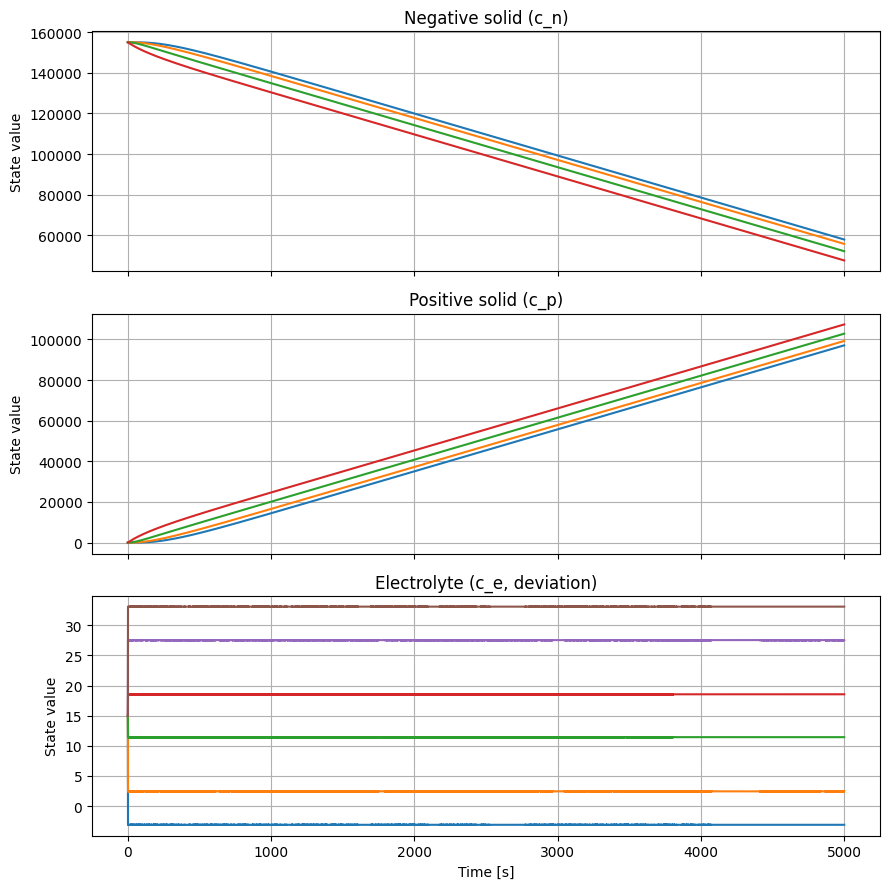

=== State Extrema Summary ===
cn      : min= 4.765e+04, max= 1.550e+05
cp      : min= 0.000e+00, max= 1.073e+05
ce      : min=-3.111e+00, max= 3.311e+01


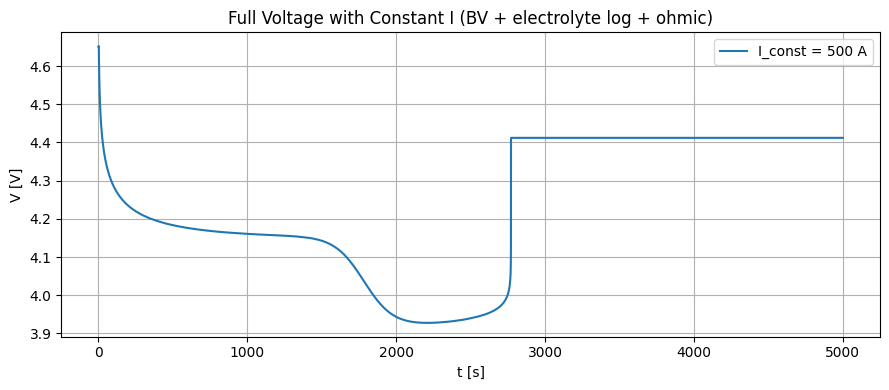

In [103]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import control as ct
from scipy.linalg import block_diag
from IPython.display import display

# =========================================================
# Configuration
# =========================================================
# Sign convention used here:
# I > 0  ==> DISCHARGE  (electrons leave the negative terminal; cation flux n->p)
I_POSITIVE_IS_DISCHARGE: bool = True

# --------------------------
# Index map (global)
# --------------------------
# x = [c_n1,c_n2,c_n3,c_n4,  c_p1,c_p2,c_p3,c_p4,  ce1,ce2,ce3,ce4,ce5,ce6]
IDX = {
    "cn": slice(0,4),
    "cp": slice(4,8),
    "ce": slice(8,14),

    # “Surface” choices used by the voltage layer (change if you like)
    "cn_surf": 2,   # cn3 as neg “surface”
    "cp_surf": 4,   # absolute index 4 (= local cp1) as pos “surface”
    "ce_left": 8,   # ce1  (near negative current collector)
    "ce_right": 13, # ce6  (near positive current collector)
}

# --------------------------
# Physical constants
# --------------------------
@dataclass
class PhysParams:
    R: float = 8.314462618    # J/(mol·K)
    F: float = 96485.33212    # C/mol
    T: float = 298.15         # K
    t_plus: float = 0.38
    kf: float = 1.0           # multiplier on the ln term
    Re: float = 0.0           # series ohmic, if used
    Rf: float = 0.0           # film (aging), if used
    csn_max: float = 3.1e4    # [mol/m^3]
    csp_max: float = 5.1e4    # [mol/m^3]

PP = PhysParams()
R_GAS = PP.R

# --------------------------
# Solid diffusion (4×4)
# --------------------------
def build_An(Dn: float, Rn: float) -> np.ndarray:
    s = Dn/(Rn**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*s,  24*s
    A[1,0], A[1,1], A[1,2] =  16*s, -40*s, 24*s
    A[2,1], A[2,2], A[2,3] =  16*s, -40*s, 24*s
    A[3,2], A[3,3] =  16*s, -16*s
    return A

def build_Bn(Dn: float, Rn: float, a: float, A: float, L_n: float, *, discharge_positive: bool = True) -> np.ndarray:
    """Input column for negative solid (last state is 'surface')."""
    sign = -1.0 if discharge_positive else +1.0
    b = np.zeros((4,1))
    b[-1,0] = sign * (6.0/Rn) * (1.0/(PP.F * a * A * L_n))
    return b

def build_Ap(Dp: float, Rp: float) -> np.ndarray:
    s = Dp/(Rp**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*s, 24*s
    A[1,0], A[1,1], A[1,2] = 16*s, -40*s, 24*s
    A[2,1], A[2,2], A[2,3] = 16*s, -40*s, 24*s
    A[3,2], A[3,3] = 16*s, -16*s
    return A

def build_Bp(Dp: float, Rp: float, a: float, A: float, L_p: float, *, discharge_positive: bool = True) -> np.ndarray:
    """Input column for positive solid (last state is 'surface')."""
    sign = +1.0 if discharge_positive else -1.0
    b = np.zeros((4,1))
    b[-1,0] = sign * (6.0/Rp) * (1.0/(PP.F * a * A * L_p))
    return b

# --------------------------
# Electrolyte diffusion (6×6) — dissipative sign (negative diagonal)
# --------------------------
def build_Ae(D_e: float, eps: float, Ln: float, Lsep: float, Lp: float) -> np.ndarray:
    K = D_e/eps
    Ae = np.zeros((6,6))
    w_in   = lambda L: K * 4.0 / (L**2)
    w_intf = lambda La, Lb: K * 16.0 / ((La + Lb)**2)

    w11 = w_in(Ln)
    w12 = w_intf(Ln, Lsep)
    w23 = w_in(Lsep)
    w34 = w_intf(Lsep, Lp)
    w45 = w_in(Lp)

    # ce1 … ce6 tri-diagonal (with interface couplings)
    Ae[0,0] = -(w11);                 Ae[0,1] = +(w11)
    Ae[1,0] = +(w11); Ae[1,1] = -(w11 + w12); Ae[1,2] = +(w12)
    Ae[2,1] = +(w12); Ae[2,2] = -(w12 + w23); Ae[2,3] = +(w23)
    Ae[3,2] = +(w23); Ae[3,3] = -(w23 + w34); Ae[3,4] = +(w34)
    Ae[4,3] = +(w34); Ae[4,4] = -(w34 + w45); Ae[4,5] = +(w45)
    Ae[5,4] = +(w45); Ae[5,5] = -(w45)
    return Ae

def build_Be(Ln: float, Lp: float, eps1: float, eps3: float, A: float, t_plus: float, *, discharge_positive: bool = True) -> np.ndarray:
    """
    Distributed source/sink in the electrode regions only (separator zero).
    If discharge_positive=True:
      left (anode side)  : net sink  (−)
      right (cathode side): net source (+)
    """
    b = np.zeros((6,1))
    sign_left  = -1.0 if discharge_positive else +1.0
    sign_right = +1.0 if discharge_positive else -1.0

    s1 = sign_left  * (1.0 - t_plus) / (PP.F * A * Ln * eps1)
    s3 = sign_right * (1.0 - t_plus) / (PP.F * A * Lp * eps3)

    b[0,0] = s1; b[1,0] = s1          # negative electrode control volumes
    b[4,0] = s3; b[5,0] = s3          # positive electrode control volumes
    return b

# --------------------------
# System assembly
# --------------------------
def assemble_system(params: dict, *, discharge_positive: bool = I_POSITIVE_IS_DISCHARGE):
    # geometry & transport
    Dn = params.get("Dn", 1e-14); Rn = params.get("Rn", 5e-6)
    Dp = params.get("Dp", 1e-14); Rp = params.get("Rp", 5e-6)
    L1 = params.get("L1", 25e-6); L2 = params.get("L2", 20e-6); L3 = params.get("L3", 25e-6)
    a_s_n = params.get("a_s_n", 1.0e6); a_s_p = params.get("a_s_p", 1.0e6)

    # area
    electrode_area = params.get("A", params.get("A_e", 1.0))

    # electrolyte
    D_e = params.get("D_e", params.get("De", 7.23e-10))
    eps = params.get("eps", 0.30)

    # build blocks with *discharge-positive* sign convention
    An = build_An(Dn, Rn)
    Ap = build_Ap(Dp, Rp)
    Bn = build_Bn(Dn, Rn, a_s_n, electrode_area, L1, discharge_positive=discharge_positive)
    Bp = build_Bp(Dp, Rp, a_s_p, electrode_area, L3, discharge_positive=discharge_positive)
    Ae = build_Ae(D_e, eps, L1, L2, L3)
    Be = build_Be(L1, L3, eps, eps, electrode_area, PP.t_plus, discharge_positive=discharge_positive)

    # global
    Aglob = block_diag(An, Ap, Ae)
    Bglob = np.vstack([Bn, Bp, Be])

    # names
    state_names = [f'cn{i}' for i in range(1,5)] + [f'cp{i}' for i in range(1,5)] + [f'ce{i}' for i in range(1,7)]

    S = ct.ss(Aglob, Bglob, np.eye(Aglob.shape[0]), np.zeros((Aglob.shape[0],1)))
    return S, Aglob, Bglob, (An, Ap, Ae, Bn, Bp, Be), state_names

# --------------------------
# Helpers: ICs, display
# --------------------------
def make_x0(theta_n0=0.2, theta_p0=0.9, ce0=0.0, pp: PhysParams = PP):
    """Build initial state (ce0 is a deviation if ce_is_deviation=True)."""
    x0 = np.zeros(14)
    x0[IDX["cn"]] = theta_n0 * pp.csn_max
    x0[IDX["cp"]] = theta_p0 * pp.csp_max
    x0[IDX["ce"]] = ce0
    return x0

def show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B, state_names):
    def df(M, rnames, cnames): return pd.DataFrame(M, index=rnames, columns=cnames)
    cn_names = [f'cn{i}' for i in range(1, An.shape[0]+1)]
    cp_names = [f'cp{i}' for i in range(1, Ap.shape[0]+1)]
    ce_names = [f'ce{i}' for i in range(1, Ae.shape[0]+1)]
    display(df(An, cn_names, cn_names)); display(df(Bn, cn_names, ['u']))
    display(df(Ap, cp_names, cp_names)); display(df(Bp, cp_names, ['u']))
    display(df(Ae, ce_names, ce_names)); display(df(Be, ce_names, ['u']))
    display(df(A, state_names, state_names)); display(df(B, state_names, ['u']))
    print("A shape:", A.shape, " B shape:", B.shape)

def plot_states_grouped(t: np.ndarray, X_TN: np.ndarray):
    fig, axs = plt.subplots(3, 1, figsize=(9, 9), sharex=True)
    axs[0].plot(t, X_TN[:, IDX["cn"]]); axs[0].set_title("Negative solid (c_n)")
    axs[1].plot(t, X_TN[:, IDX["cp"]]); axs[1].set_title("Positive solid (c_p)")
    axs[2].plot(t, X_TN[:, IDX["ce"]]); axs[2].set_title("Electrolyte (c_e, deviation)")
    for ax in axs: ax.grid(True); ax.set_ylabel("State value")
    axs[-1].set_xlabel("Time [s]"); plt.tight_layout(); plt.show()

def report_extrema_matrix(X_TN: np.ndarray):
    print("=== State Extrema Summary ===")
    for name in ["cn","cp","ce"]:
        arr = X_TN[:, IDX[name]]
        print(f"{name:<8s}: min={arr.min(): .3e}, max={arr.max(): .3e}")

# --------------------------
# OCVs & Voltage params
# --------------------------
def ocp_p_safe(xp: np.ndarray) -> np.ndarray:
    xp = np.clip(xp, 1e-6, 1-1e-6)
    return 4.15 - 0.12*np.tanh((xp - 0.60)/0.08)

def ocp_n_safe(xn: np.ndarray) -> np.ndarray:
    xn = np.clip(xn, 1e-6, 1-1e-6)
    return 0.10 + 0.80*(1/(1 + np.exp(-(xn-0.50)/0.04)))

@dataclass
class VParams:
    A: float = 1.0
    L_n: float = 25e-6
    L_p: float = 25e-6
    a_s_n: float = 1.0e6
    a_s_p: float = 1.0e6
    k_n: float = 2.0e-11
    k_p: float = 2.0e-11
    cs_n_max: float = 3.1e4
    cs_p_max: float = 5.1e4
    ce0: float = 1000.0
    t_plus: float = PP.t_plus
    k_f: float = 1.0
    Re: float = 0.0
    Rf: float = 0.0
    R_ohm: float = 0.0
    T: float = 298.15
    ce_is_deviation: bool = True

# --------------------------
# FULL terminal voltage with a CONSTANT user-set I_bat
# --------------------------
def _i0_scales_scalar(xp, xn, ceL, ceR, vp: VParams):
    """Exchange-current scales for symmetric BV (α = 0.5)."""
    F = PP.F
    Sp = vp.a_s_p * vp.A * vp.L_p
    Sn = vp.a_s_n * vp.A * vp.L_n
    ce_kin = np.clip(0.5*(ceL + ceR), 0.2*vp.ce0, 5.0*vp.ce0)
    xp = np.clip(xp, 1e-9, 1-1e-9)
    xn = np.clip(xn, 1e-9, 1-1e-9)
    I0p = F * vp.k_p * Sp * vp.cs_p_max * np.sqrt(ce_kin) * np.sqrt(xp*(1 - xp))
    I0n = F * vp.k_n * Sn * vp.cs_n_max * np.sqrt(ce_kin) * np.sqrt(xn*(1 - xn))
    return float(I0p), float(I0n)

def voltage_full_constI(x: np.ndarray,
                        vp: VParams,
                        I_const: float,
                        *,
                        ln_orientation: str = "right_over_left",
                        eta_sign: str = "sum",
                        return_terms: bool = False):
    """
    Full terminal voltage at CONSTANT current I_const (discharge-positive):
      V = (Up - Un) + η_p(I_const) ± η_n(I_const)
          + (2RT/F)(1 - t+) k_f ln(ceR/ceL)  -  (Re + Rf + R_ohm) * I_const

    eta_sign:
      "sum"  -> η_p + η_n    (matches many SPM/SPMe writeups)
      "diff" -> η_n - η_p    (alternative sign grouping seen in some texts)
    """
    # surface stoichiometries
    xp = np.clip(x[IDX["cp_surf"]]/vp.cs_p_max, 1e-9, 1-1e-9)
    xn = np.clip(x[IDX["cn_surf"]]/vp.cs_n_max, 1e-9, 1-1e-9)
    Up, Un = float(ocp_p_safe(np.array([xp]))[0]), float(ocp_n_safe(np.array([xn]))[0])

    # electrolyte end concentrations (deviation or absolute)
    ceL_raw = x[IDX["ce_left"]];  ceR_raw = x[IDX["ce_right"]]
    ceL = (vp.ce0 + ceL_raw) if vp.ce_is_deviation else ceL_raw
    ceR = (vp.ce0 + ceR_raw) if vp.ce_is_deviation else ceR_raw
    ceL = float(max(ceL, 1e-12)); ceR = float(max(ceR, 1e-12))

    # electrolyte log term
    ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
    dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(max(ln_arg, 1e-12))

    # BV overpotentials (α=0.5)
    I0p, I0n = _i0_scales_scalar(xp, xn, ceL, ceR, vp)
    # protect against very small I0
    denom_p = max(I0p, 1e-20); denom_n = max(I0n, 1e-20)
    eta_p = (2.0*R_GAS*vp.T/PP.F) * np.arcsinh(0.5*I_const / denom_p)
    eta_n = (2.0*R_GAS*vp.T/PP.F) * np.arcsinh(0.5*I_const / denom_n)
    eta_combo = (eta_n - eta_p) if (eta_sign == "diff") else (eta_p + eta_n)

    # Ohmic (lumped)
    ohmic = -(vp.Re + vp.Rf + vp.R_ohm) * I_const

    V = (Up - Un) + eta_combo + dphi_e + ohmic

    if return_terms:
        return float(V), {
            "Up":Up, "Un":Un, "Udiff":Up-Un,
            "eta_p":eta_p, "eta_n":eta_n, "eta_combo":eta_combo,
            "dphi_e":dphi_e, "ohmic":ohmic
        }
    return float(V)

# --------------------------
# Nonlinear IOSystem wrappers
# --------------------------
def battery_update(t, x, u, params):
    """
    xdot = A x + B * I_dyn,   where I_dyn is a CONSTANT you set for the state dynamics.
    This keeps dynamics independent from your voltage plotting knob.
    """
    A = params["A"]; B = params["B"]
    I_dyn = params.get("I_dyn", 0.0)   # choose the dynamics current independently
    return (A @ x + B[:, 0] * I_dyn)

def battery_output(t, x, u, params):
    """
    Return states + V_full_constI (last channel).
    V uses the constant knob I_const_for_voltage (independent of I_dyn).
    """
    vp = params["vpar"]
    Iset = params["I_const_for_voltage"]  # <--- your voltage knob
    Vfull = voltage_full_constI(x, vp, Iset, eta_sign=params.get("eta_sign","sum"))
    return np.hstack([x, Vfull])

# =========================================================
# Example (run to test)
# =========================================================
if __name__ == "__main__":
    params = dict(
        Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
        a_s_n=1.0e6, a_s_p=1.0e6, A=1.0,
        L1=25e-6, L2=20e-6, L3=25e-6,
        D_e=7.23e-10, eps=0.30,
    )

    # --- assemble the linear diffusion/transport core ---
    S, A, B, (An, Ap, Ae, Bn, Bp, Be), state_names = assemble_system(params)

    # --- voltage parameters ---
    vpar = VParams(
        A=params["A"], L_n=params["L1"], L_p=params["L3"],
        a_s_n=params["a_s_n"], a_s_p=params["a_s_p"],
        cs_n_max=PP.csn_max, cs_p_max=PP.csp_max,
        ce0=1000.0, t_plus=PP.t_plus, k_f=1.0,
        Re=0.0, Rf=0.0, R_ohm=0.0, T=PP.T,
        ce_is_deviation=True
    )

    # ===== choose the currents =====
    I_DYN  = 100   # A -> dynamics current (states): try 0.0, +0.5, +1.0, etc
    I_CONST = +500   # A -> voltage plotting knob (full V uses this constant)

    # --- pack params for nlsys ---
    nl_params = dict(A=A, B=B, vpar=vpar,
                     I_dyn=I_DYN,
                     I_const_for_voltage=I_CONST,
                     eta_sign="sum")

    # --- create nonlinear IOSystem (no exogenous input) ---
    battery_nl = ct.nlsys(
        battery_update, battery_output,
        name="battery_constI_voltage", params=nl_params,
        states=state_names,                      # 14 states
        outputs=state_names + ["V_full_constI"], # states + V(I=const)
        inputs=0                                 # no external u
    )

    # --- simulate ---
    T = np.linspace(0, 5000, 300000)
    x0 = make_x0(theta_n0=5.0, theta_p0=0.0, ce0=15.0)

    resp = ct.input_output_response(battery_nl, T, 0, X0=x0)
    t = resp.time
    X = resp.states             # shape (n_states, len(t))
    Y = resp.outputs            # shape (n_states+1, len(t))
    Vout = Y[-1, :]             # last channel is V_full_constI

    # --- quick plots ---
    plot_states_grouped(t, X.T)
    report_extrema_matrix(X.T)

    plt.figure(figsize=(9,4))
    plt.plot(t, Vout, label=f"I_const = {I_CONST} A")
    plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
    plt.title("Full Voltage with Constant I (BV + electrolyte log + ohmic)")
    plt.legend(); plt.tight_layout(); plt.show()


C:\Users\onyer\AppData\Local\Temp\ipykernel_15992\2829444918.py:255: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  I = float(u)
C:\Users\onyer\AppData\Local\Temp\ipykernel_15992\2829444918.py:257: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.hstack([x, float(V), I])  # states + V + I
C:\Users\onyer\AppData\Local\Temp\ipykernel_15992\2829444918.py:250: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  I = float(u)  # exogenous input


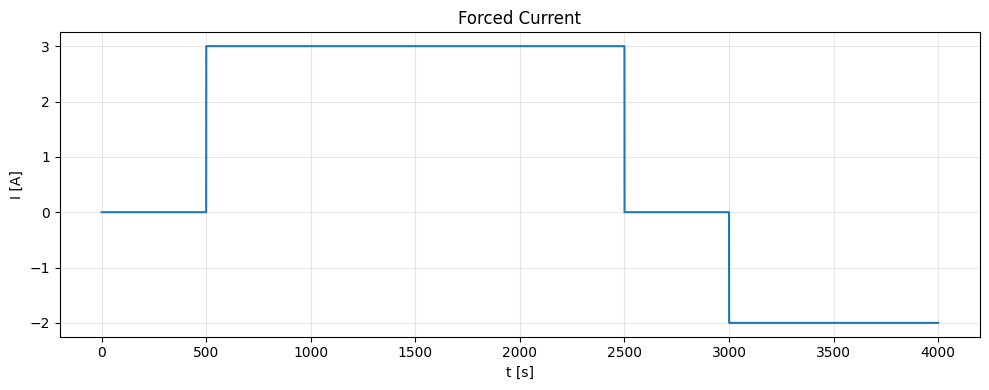

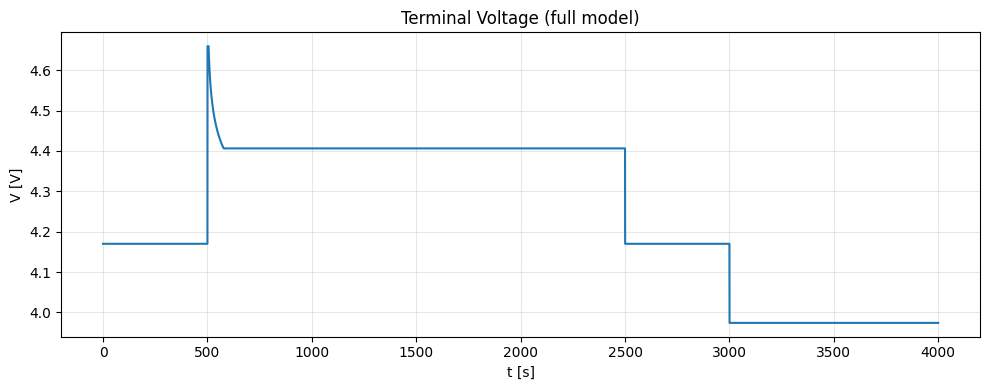

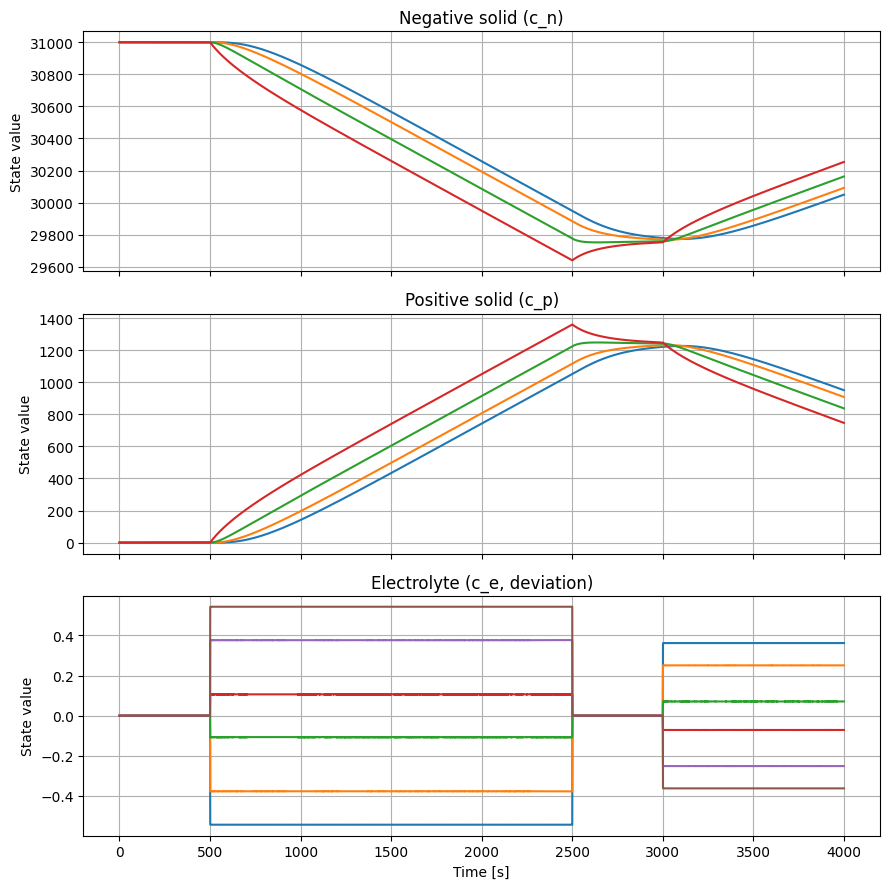

In [83]:
# ============================================
# A) Full Voltage Model (forced current input)
# ============================================
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import control as ct
from scipy.linalg import block_diag
from IPython.display import display

# =========================================================
# Configuration
# =========================================================
# I > 0 ⇒ DISCHARGE (electrons leave negative terminal)
I_POSITIVE_IS_DISCHARGE: bool = True

# --------------------------
# Index map (global)
# --------------------------
# x = [c_n1,c_n2,c_n3,c_n4, c_p1,c_p2,c_p3,c_p4, ce1,ce2,ce3,ce4,ce5,ce6]
IDX = {
    "cn": slice(0,4),
    "cp": slice(4,8),
    "ce": slice(8,14),
    # "surface"/end nodes used by voltage layer
    "cn_surf": 2,    # cn3 as neg "surface"
    "cp_surf": 4,    # absolute index 4 (= local cp1) as pos "surface"
    "ce_left": 8,    # ce1  (negative-collector end)
    "ce_right": 13,  # ce6  (positive-collector end)
}

# --------------------------
# Physical constants
# --------------------------
@dataclass
class PhysParams:
    R: float = 8.314462618    # J/(mol·K)
    F: float = 96485.33212    # C/mol
    T: float = 298.15         # K
    t_plus: float = 0.38
    kf: float = 1.0           # multiplier on ln term
    Re: float = 0.0           # series ohmic (tabs/electrolyte lump), if used
    Rf: float = 0.0           # film (aging), if used
    csn_max: float = 3.1e4    # mol/m^3
    csp_max: float = 5.1e4    # mol/m^3

PP = PhysParams()
R_GAS = PP.R

# --------------------------
# Solid diffusion (4×4)
# --------------------------
def build_An(Dn: float, Rn: float) -> np.ndarray:
    s = Dn/(Rn**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*s,  24*s
    A[1,0], A[1,1], A[1,2] =  16*s, -40*s, 24*s
    A[2,1], A[2,2], A[2,3] =  16*s, -40*s, 24*s
    A[3,2], A[3,3] =  16*s, -16*s
    return A

def build_Bn(Dn: float, Rn: float, a: float, A: float, L_n: float, *, discharge_positive: bool=True) -> np.ndarray:
    sign = -1.0 if discharge_positive else +1.0
    b = np.zeros((4,1))
    b[-1,0] = sign * (6.0/Rn) * (1.0/(PP.F * a * A * L_n))
    return b

def build_Ap(Dp: float, Rp: float) -> np.ndarray:
    s = Dp/(Rp**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*s, 24*s
    A[1,0], A[1,1], A[1,2] = 16*s, -40*s, 24*s
    A[2,1], A[2,2], A[2,3] = 16*s, -40*s, 24*s
    A[3,2], A[3,3] = 16*s, -16*s
    return A

def build_Bp(Dp: float, Rp: float, a: float, A: float, L_p: float, *, discharge_positive: bool=True) -> np.ndarray:
    sign = +1.0 if discharge_positive else -1.0
    b = np.zeros((4,1))
    b[-1,0] = sign * (6.0/Rp) * (1.0/(PP.F * a * A * L_p))
    return b

# --------------------------
# Electrolyte diffusion (6×6)
# --------------------------
def build_Ae(D_e: float, eps: float, Ln: float, Lsep: float, Lp: float) -> np.ndarray:
    # If you prefer Bruggeman: K = D_e * eps**0.5  (instead of D_e/eps)
    K = D_e/eps
    Ae = np.zeros((6,6))
    w_in   = lambda L: K * 4.0 / (L**2)
    w_intf = lambda La, Lb: K * 16.0 / ((La + Lb)**2)

    w11 = w_in(Ln)
    w12 = w_intf(Ln, Lsep)
    w23 = w_in(Lsep)
    w34 = w_intf(Lsep, Lp)
    w45 = w_in(Lp)

    Ae[0,0] = -(w11); Ae[0,1] = +(w11)
    Ae[1,0] = +(w11); Ae[1,1] = -(w11 + w12); Ae[1,2] = +(w12)
    Ae[2,1] = +(w12); Ae[2,2] = -(w12 + w23); Ae[2,3] = +(w23)
    Ae[3,2] = +(w23); Ae[3,3] = -(w23 + w34); Ae[3,4] = +(w34)
    Ae[4,3] = +(w34); Ae[4,4] = -(w34 + w45); Ae[4,5] = +(w45)
    Ae[5,4] = +(w45); Ae[5,5] = -(w45)
    return Ae

def build_Be(Ln: float, Lp: float, eps1: float, eps3: float, A: float, t_plus: float, *, discharge_positive: bool=True) -> np.ndarray:
    b = np.zeros((6,1))
    sign_left  = -1.0 if discharge_positive else +1.0 # negative electrode region
    sign_right = +1.0 if discharge_positive else -1.0 # positive electrode region
    s1 = sign_left  * (1.0 - t_plus) / (PP.F * A * Ln * eps1)
    s3 = sign_right * (1.0 - t_plus) / (PP.F * A * Lp * eps3)
    b[0,0] = s1; b[1,0] = s1
    b[4,0] = s3; b[5,0] = s3
    return b

# --------------------------
# System assembly
# --------------------------
def assemble_system(params: dict, *, discharge_positive: bool=I_POSITIVE_IS_DISCHARGE):
    Dn = params.get("Dn", 1e-14); Rn = params.get("Rn", 5e-6)
    Dp = params.get("Dp", 1e-14); Rp = params.get("Rp", 5e-6)
    L1 = params.get("L1", 25e-6); L2 = params.get("L2", 20e-6); L3 = params.get("L3", 25e-6)
    a_s_n = params.get("a_s_n", 1.0e6); a_s_p = params.get("a_s_p", 1.0e6)

    area = params.get("A", params.get("A_e", 1.0))
    D_e = params.get("D_e", params.get("De", 7.23e-10))
    eps = params.get("eps", 0.30)

    An = build_An(Dn, Rn)
    Ap = build_Ap(Dp, Rp)
    Bn = build_Bn(Dn, Rn, a_s_n, area, L1, discharge_positive=discharge_positive)
    Bp = build_Bp(Dp, Rp, a_s_p, area, L3, discharge_positive=discharge_positive)
    Ae = build_Ae(D_e, eps, L1, L2, L3)
    Be = build_Be(L1, L3, eps, eps, area, PP.t_plus, discharge_positive=discharge_positive)

    Aglob = block_diag(An, Ap, Ae)
    Bglob = np.vstack([Bn, Bp, Be])
    state_names = [f'cn{i}' for i in range(1,5)] + [f'cp{i}' for i in range(1,5)] + [f'ce{i}' for i in range(1,7)]
    S = ct.ss(Aglob, Bglob, np.eye(Aglob.shape[0]), np.zeros((Aglob.shape[0],1)))
    return S, Aglob, Bglob, (An, Ap, Ae, Bn, Bp, Be), state_names

# --------------------------
# Helpers
# --------------------------
def make_x0(theta_n0=0.2, theta_p0=0.9, ce0=0.0, pp: PhysParams=PP):
    x0 = np.zeros(14)
    x0[IDX["cn"]] = theta_n0 * pp.csn_max
    x0[IDX["cp"]] = theta_p0 * pp.csp_max
    x0[IDX["ce"]] = ce0
    return x0

def plot_states_grouped(t: np.ndarray, X_TN: np.ndarray):
    fig, axs = plt.subplots(3, 1, figsize=(9,9), sharex=True)
    axs[0].plot(t, X_TN[:, IDX["cn"]]); axs[0].set_title("Negative solid (c_n)")
    axs[1].plot(t, X_TN[:, IDX["cp"]]); axs[1].set_title("Positive solid (c_p)")
    axs[2].plot(t, X_TN[:, IDX["ce"]]); axs[2].set_title("Electrolyte (c_e, deviation)")
    for ax in axs: ax.grid(True); ax.set_ylabel("State value")
    axs[-1].set_xlabel("Time [s]"); plt.tight_layout(); plt.show()

# --------------------------
# OCVs & Voltage params
# --------------------------
def ocp_p_safe(xp: np.ndarray) -> np.ndarray:
    xp = np.clip(xp, 1e-6, 1-1e-6)
    return 4.15 - 0.12*np.tanh((xp - 0.60)/0.08)

def ocp_n_safe(xn: np.ndarray) -> np.ndarray:
    xn = np.clip(xn, 1e-6, 1-1e-6)
    return 0.10 + 0.80*(1/(1 + np.exp(-(xn-0.50)/0.04)))

@dataclass
class VParams:
    A: float = 1.0
    L_n: float = 25e-6
    L_p: float = 25e-6
    a_s_n: float = 1.0e6
    a_s_p: float = 1.0e6
    k_n: float = 2.0e-11
    k_p: float = 2.0e-11
    cs_n_max: float = 3.1e4
    cs_p_max: float = 5.1e4
    ce0: float = 1000.0
    t_plus: float = PP.t_plus
    k_f: float = 1.0
    Re: float = 0.0
    Rf: float = 0.0
    R_ohm: float = 0.0
    T: float = 298.15
    ce_is_deviation: bool = True

def _extract_surface_and_ce(X_TN: np.ndarray, vp: VParams):
    xp = np.clip(X_TN[:, IDX["cp_surf"]], 1e-9, 1-1e-9) / vp.cs_p_max
    xn = np.clip(X_TN[:, IDX["cn_surf"]], 1e-9, 1-1e-9) / vp.cs_n_max
    ceL_raw = X_TN[:, IDX["ce_left"]]
    ceR_raw = X_TN[:, IDX["ce_right"]]
    ceL = (vp.ce0 + ceL_raw) if vp.ce_is_deviation else ceL_raw
    ceR = (vp.ce0 + ceR_raw) if vp.ce_is_deviation else ceR_raw
    ceL = np.clip(ceL, 1e-9, None); ceR = np.clip(ceR, 1e-9, None)
    return xp, xn, ceL, ceR

def _i0_scales(xp, xn, ceL, ceR, vp: VParams):
    F = PP.F
    Sp = vp.a_s_p * vp.A * vp.L_p
    Sn = vp.a_s_n * vp.A * vp.L_n
    ce_kin = 0.5*(ceL + ceR)
    ce_kin = np.clip(ce_kin, 0.2*vp.ce0, 5.0*vp.ce0)
    xp_clip = np.clip(xp, 1e-9, 1-1e-9)
    xn_clip = np.clip(xn, 1e-9, 1-1e-9)
    I0p = F * vp.k_p * Sp * vp.cs_p_max * np.sqrt(ce_kin) * np.sqrt(xp_clip*(1 - xp_clip))
    I0n = F * vp.k_n * Sn * vp.cs_n_max * np.sqrt(ce_kin) * np.sqrt(xn_clip*(1 - xn_clip))
    return I0p, I0n

def voltage_full(T: np.ndarray,
                 X_TN: np.ndarray,
                 I: np.ndarray,
                 vp: VParams,
                 *,
                 ln_orientation: str = "right_over_left",
                 eta_sign: str = "sum"):
    """
    Full terminal voltage (vectorized):
      V = (Up - Un) + η_p + η_n + (2RT/F)(1-t+)k_f ln(ceR/ceL) - (Re + Rf + R_ohm) I
    """
    I = np.asarray(I).reshape(-1)
    xp, xn, ceL, ceR = _extract_surface_and_ce(X_TN, vp)
    Up, Un = ocp_p_safe(xp), ocp_n_safe(xn)

    ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
    dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(np.clip(ln_arg, 1e-12, None))

    I0p, I0n = _i0_scales(xp, xn, ceL, ceR, vp)
    eta_p = (2.0*R_GAS*vp.T/PP.F) * np.arcsinh(0.5*I / np.clip(I0p, 1e-20, None))
    eta_n = (2.0*R_GAS*vp.T/PP.F) * np.arcsinh(0.5*I / np.clip(I0n, 1e-20, None))
    eta_sum = (eta_n - eta_p) if (eta_sign == "diff") else (eta_p + eta_n)

    ohmic = -(vp.Re + vp.Rf + vp.R_ohm) * I
    V = (Up - Un) + eta_sum + dphi_e + ohmic
    return V, {"Udiff":Up-Un, "eta_p":eta_p, "eta_n":eta_n, "eta_sum":eta_sum,
               "dphi_e":dphi_e, "ohmic":ohmic, "V":V, "xp":xp, "xn":xn,
               "ceL":ceL, "ceR":ceR, "I0p":I0p, "I0n":I0n}

# --------------------------
# Forced-current IO system
# --------------------------
def battery_update_forced(t, x, u, params):
    A = params["A"]; B = params["B"]
    I = float(u)  # exogenous input
    return A @ x + B[:,0] * I

def battery_output_forced(t, x, u, params):
    vp = params["vpar"]
    I = float(u)
    V, _parts = voltage_full(np.array([t]), x.reshape(1,-1), np.array([I]), vp)
    return np.hstack([x, float(V), I])  # states + V + I

# =========================================================
# Demo (forced current profile)
# =========================================================
if __name__ == "__main__":
    params = dict(Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
                  a_s_n=1.0e6, a_s_p=1.0e6, A=1.0,
                  L1=25e-6, L2=20e-6, L3=25e-6,
                  D_e=7.23e-10, eps=0.30)

    S, A, B, (An, Ap, Ae, Bn, Bp, Be), state_names = assemble_system(params)
    vpar = VParams(A=params["A"], L_n=params["L1"], L_p=params["L3"],
                   a_s_n=params["a_s_n"], a_s_p=params["a_s_p"],
                   cs_n_max=PP.csn_max, cs_p_max=PP.csp_max,
                   ce0=1000.0, t_plus=PP.t_plus, k_f=1.0,
                   Re=0.0, Rf=0.0, R_ohm=0.0, T=PP.T, ce_is_deviation=True)

    nl_params = dict(A=A, B=B, vpar=vpar)
    battery_nl = ct.nlsys(
        battery_update_forced, battery_output_forced,
        name="battery_forced_current", params=nl_params,
        states=state_names, outputs=state_names + ["V", "I"], inputs=1
    )

    # time grid & current profile (piecewise)
    T = np.linspace(0, 4000, 80001)
    def I_profile(t):
        # 0-500s: rest; 500-2500s: +3A discharge; 2500-3000s: rest; 3000-4000s: -2A charge
        return (0.0 if t < 500 else
                3.0 if t < 2500 else
                0.0 if t < 3000 else
               -2.0)

    U = np.array([I_profile(tt) for tt in T]).reshape(1,-1)
    x0 = make_x0(theta_n0=1.0, theta_p0=0.0, ce0=0.0)

    resp = ct.input_output_response(battery_nl, T, U, X0=x0)
    t = resp.time
    X = resp.states
    Y = resp.outputs
    V = Y[-2,:]; I = Y[-1,:]

    # quick plots
    plt.figure(figsize=(10,4)); plt.plot(t, I); plt.grid(True, alpha=0.3)
    plt.ylabel("I [A]"); plt.xlabel("t [s]"); plt.title("Forced Current"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4)); plt.plot(t, V); plt.grid(True, alpha=0.3)
    plt.ylabel("V [V]"); plt.xlabel("t [s]"); plt.title("Terminal Voltage (full model)"); plt.tight_layout(); plt.show()

    plot_states_grouped(t, X.T)


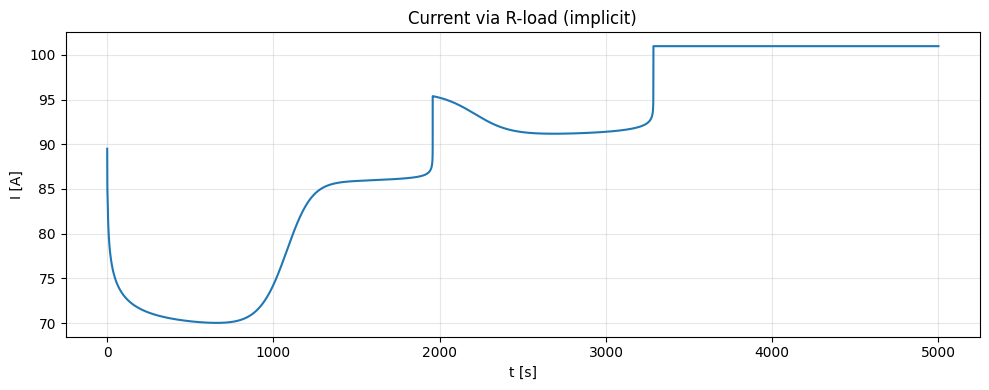

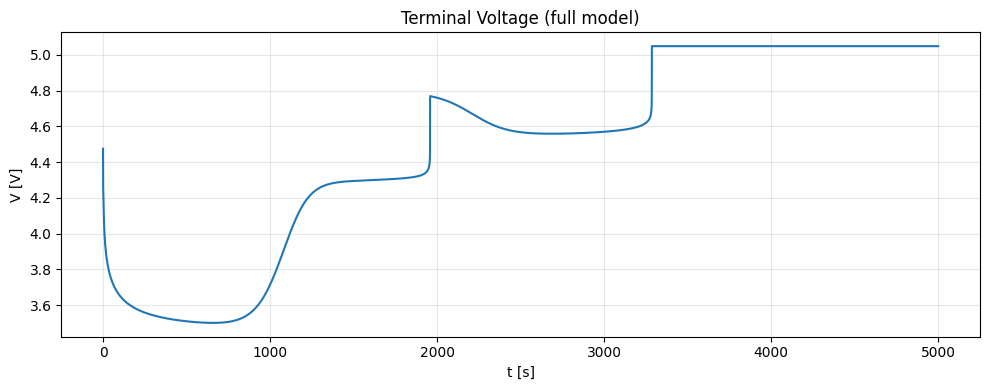

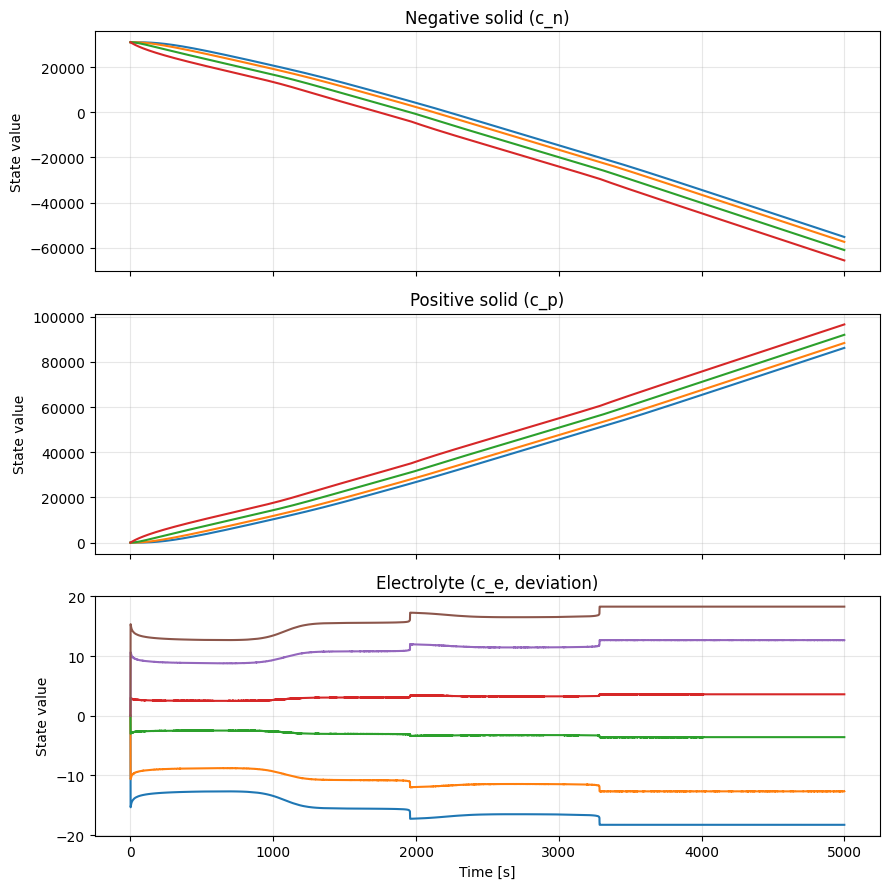

In [85]:
# =======================================================
# B) R-load + Full Voltage (implicit current via secant)
# =======================================================
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import control as ct
from scipy.linalg import block_diag
from IPython.display import display

# =========================================================
# Configuration
# =========================================================
I_POSITIVE_IS_DISCHARGE: bool = True  # I > 0 ⇒ discharge

# --------------------------
# Index map (global)
# --------------------------
IDX = {
    "cn": slice(0,4),
    "cp": slice(4,8),
    "ce": slice(8,14),
    "cn_surf": 2,
    "cp_surf": 4,
    "ce_left": 8,
    "ce_right": 13,
}

# --------------------------
# Physical constants
# --------------------------
@dataclass
class PhysParams:
    R: float = 8.314462618
    F: float = 96485.33212
    T: float = 298.15
    t_plus: float = 0.38
    kf: float = 1.0
    Re: float = 0.0
    Rf: float = 0.0
    csn_max: float = 3.1e4
    csp_max: float = 5.1e4

PP = PhysParams()
R_GAS = PP.R

# --------------------------
# Solid diffusion (4×4)
# --------------------------
def build_An(Dn: float, Rn: float) -> np.ndarray:
    s = Dn/(Rn**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*s,  24*s
    A[1,0], A[1,1], A[1,2] =  16*s, -40*s, 24*s
    A[2,1], A[2,2], A[2,3] =  16*s, -40*s, 24*s
    A[3,2], A[3,3] =  16*s, -16*s
    return A

def build_Bn(Dn: float, Rn: float, a: float, A: float, L_n: float, *, discharge_positive: bool=True) -> np.ndarray:
    sign = -1.0 if discharge_positive else +1.0
    b = np.zeros((4,1))
    b[-1,0] = sign * (6.0/Rn) * (1.0/(PP.F * a * A * L_n))
    return b

def build_Ap(Dp: float, Rp: float) -> np.ndarray:
    s = Dp/(Rp**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*s, 24*s
    A[1,0], A[1,1], A[1,2] = 16*s, -40*s, 24*s
    A[2,1], A[2,2], A[2,3] = 16*s, -40*s, 24*s
    A[3,2], A[3,3] = 16*s, -16*s
    return A

def build_Bp(Dp: float, Rp: float, a: float, A: float, L_p: float, *, discharge_positive: bool=True) -> np.ndarray:
    sign = +1.0 if discharge_positive else -1.0
    b = np.zeros((4,1))
    b[-1,0] = sign * (6.0/Rp) * (1.0/(PP.F * a * A * L_p))
    return b

# --------------------------
# Electrolyte diffusion (6×6)
# --------------------------
def build_Ae(D_e: float, eps: float, Ln: float, Lsep: float, Lp: float) -> np.ndarray:
    K = D_e/eps
    Ae = np.zeros((6,6))
    w_in   = lambda L: K * 4.0 / (L**2)
    w_intf = lambda La, Lb: K * 16.0 / ((La + Lb)**2)

    w11 = w_in(Ln)
    w12 = w_intf(Ln, Lsep)
    w23 = w_in(Lsep)
    w34 = w_intf(Lsep, Lp)
    w45 = w_in(Lp)

    Ae[0,0] = -(w11); Ae[0,1] = +(w11)
    Ae[1,0] = +(w11); Ae[1,1] = -(w11 + w12); Ae[1,2] = +(w12)
    Ae[2,1] = +(w12); Ae[2,2] = -(w12 + w23); Ae[2,3] = +(w23)
    Ae[3,2] = +(w23); Ae[3,3] = -(w23 + w34); Ae[3,4] = +(w34)
    Ae[4,3] = +(w34); Ae[4,4] = -(w34 + w45); Ae[4,5] = +(w45)
    Ae[5,4] = +(w45); Ae[5,5] = -(w45)
    return Ae

def build_Be(Ln: float, Lp: float, eps1: float, eps3: float, A: float, t_plus: float, *, discharge_positive: bool=True) -> np.ndarray:
    b = np.zeros((6,1))
    sign_left  = -1.0 if discharge_positive else +1.0
    sign_right = +1.0 if discharge_positive else -1.0
    s1 = sign_left  * (1.0 - t_plus) / (PP.F * A * Ln * eps1)
    s3 = sign_right * (1.0 - t_plus) / (PP.F * A * Lp * eps3)
    b[0,0] = s1; b[1,0] = s1
    b[4,0] = s3; b[5,0] = s3
    return b

# --------------------------
# System assembly
# --------------------------
def assemble_system(params: dict, *, discharge_positive: bool=I_POSITIVE_IS_DISCHARGE):
    Dn = params.get("Dn", 1e-14); Rn = params.get("Rn", 5e-6)
    Dp = params.get("Dp", 1e-14); Rp = params.get("Rp", 5e-6)
    L1 = params.get("L1", 25e-6); L2 = params.get("L2", 20e-6); L3 = params.get("L3", 25e-6)
    a_s_n = params.get("a_s_n", 1.0e6); a_s_p = params.get("a_s_p", 1.0e6)
    area = params.get("A", params.get("A_e", 1.0))
    D_e = params.get("D_e", params.get("De", 7.23e-10))
    eps = params.get("eps", 0.30)

    An = build_An(Dn, Rn)
    Ap = build_Ap(Dp, Rp)
    Bn = build_Bn(Dn, Rn, a_s_n, area, L1, discharge_positive=discharge_positive)
    Bp = build_Bp(Dp, Rp, a_s_p, area, L3, discharge_positive=discharge_positive)
    Ae = build_Ae(D_e, eps, L1, L2, L3)
    Be = build_Be(L1, L3, eps, eps, area, PP.t_plus, discharge_positive=discharge_positive)

    Aglob = block_diag(An, Ap, Ae)
    Bglob = np.vstack([Bn, Bp, Be])
    state_names = [f'cn{i}' for i in range(1,5)] + [f'cp{i}' for i in range(1,5)] + [f'ce{i}' for i in range(1,7)]
    S = ct.ss(Aglob, Bglob, np.eye(Aglob.shape[0]), np.zeros((Aglob.shape[0],1)))
    return S, Aglob, Bglob, (An, Ap, Ae, Bn, Bp, Be), state_names

# --------------------------
# Helpers
# --------------------------
def make_x0(theta_n0=0.2, theta_p0=0.9, ce0=0.0, pp: PhysParams=PP):
    x0 = np.zeros(14)
    x0[IDX["cn"]] = theta_n0 * pp.csn_max
    x0[IDX["cp"]] = theta_p0 * pp.csp_max
    x0[IDX["ce"]] = ce0
    return x0

def plot_states_grouped(t: np.ndarray, X_TN: np.ndarray):
    fig, axs = plt.subplots(3, 1, figsize=(9,9), sharex=True)
    axs[0].plot(t, X_TN[:, IDX["cn"]]); axs[0].set_title("Negative solid (c_n)")
    axs[1].plot(t, X_TN[:, IDX["cp"]]); axs[1].set_title("Positive solid (c_p)")
    axs[2].plot(t, X_TN[:, IDX["ce"]]); axs[2].set_title("Electrolyte (c_e, deviation)")
    for ax in axs: ax.grid(True, alpha=0.3); ax.set_ylabel("State value")
    axs[-1].set_xlabel("Time [s]"); plt.tight_layout(); plt.show()

# --------------------------
# OCVs & Voltage params
# --------------------------
def ocp_p_safe(xp: np.ndarray) -> np.ndarray:
    xp = np.clip(xp, 1e-6, 1-1e-6)
    return 4.15 - 0.12*np.tanh((xp - 0.60)/0.08)

def ocp_n_safe(xn: np.ndarray) -> np.ndarray:
    xn = np.clip(xn, 1e-6, 1-1e-6)
    return 0.10 + 0.80*(1/(1 + np.exp(-(xn-0.50)/0.04)))

@dataclass
class VParams:
    A: float = 1.0
    L_n: float = 25e-6
    L_p: float = 25e-6
    a_s_n: float = 1.0e6
    a_s_p: float = 1.0e6
    k_n: float = 2.0e-11
    k_p: float = 2.0e-11
    cs_n_max: float = 3.1e4
    cs_p_max: float = 5.1e4
    ce0: float = 1000.0
    t_plus: float = PP.t_plus
    k_f: float = 1.0
    Re: float = 0.0
    Rf: float = 0.0
    R_ohm: float = 0.0
    T: float = 298.15
    ce_is_deviation: bool = True

def _extract_surface_and_ce_vec(X_TN_row: np.ndarray, vp: VParams):
    xp = np.clip(X_TN_row[IDX["cp_surf"]]/vp.cs_p_max, 1e-9, 1-1e-9)
    xn = np.clip(X_TN_row[IDX["cn_surf"]]/vp.cs_n_max, 1e-9, 1-1e-9)
    ceL_raw = X_TN_row[IDX["ce_left"]]; ceR_raw = X_TN_row[IDX["ce_right"]]
    ceL = (vp.ce0 + ceL_raw) if vp.ce_is_deviation else ceL_raw
    ceR = (vp.ce0 + ceR_raw) if vp.ce_is_deviation else ceR_raw
    ceL = max(ceL, 1e-12); ceR = max(ceR, 1e-12)
    return xp, xn, ceL, ceR

def _i0_scales_scalar(xp, xn, ceL, ceR, vp: VParams):
    F = PP.F
    Sp = vp.a_s_p * vp.A * vp.L_p
    Sn = vp.a_s_n * vp.A * vp.L_n
    ce_kin = np.clip(0.5*(ceL + ceR), 0.2*vp.ce0, 5.0*vp.ce0)
    I0p = F * vp.k_p * Sp * vp.cs_p_max * np.sqrt(ce_kin) * np.sqrt(np.clip(xp*(1 - xp),1e-9,None))
    I0n = F * vp.k_n * Sn * vp.cs_n_max * np.sqrt(ce_kin) * np.sqrt(np.clip(xn*(1 - xn),1e-9,None))
    return float(I0p), float(I0n)

def _current_from_Rload(x: np.ndarray, vp: VParams, R_load: float,
                        ln_orientation: str = "right_over_left",
                        eta_sign: str = "sum",
                        I_hint: float = 0.0,
                        max_iter: int = 30, tol: float = 1e-10):
    # terms independent of I
    xp, xn, ceL, ceR = _extract_surface_and_ce_vec(x, vp)
    Up, Un = ocp_p_safe(np.array([xp]))[0], ocp_n_safe(np.array([xn]))[0]
    ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
    dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(max(ln_arg, 1e-12))
    U0 = (Up - Un) + dphi_e
    Rser = vp.Re + vp.Rf + vp.R_ohm
    I0p, I0n = _i0_scales_scalar(xp, xn, ceL, ceR, vp)

    def eta_sum(I):
        ep = (2.0*R_GAS*vp.T/PP.F) * np.arcsinh(0.5*I / max(I0p, 1e-20))
        en = (2.0*R_GAS*vp.T/PP.F) * np.arcsinh(0.5*I / max(I0n, 1e-20))
        return (en - ep) if (eta_sign == "diff") else (ep + en)

    def f(I):
        return (R_load + Rser)*I - (U0 + eta_sum(I))

    I0 = I_hint if I_hint != 0 else U0 / max(R_load + Rser, 1e-12)
    I1 = I0 + 1e-3
    f0, f1 = f(I0), f(I1)
    for _ in range(max_iter):
        denom = (f1 - f0)
        if abs(denom) < 1e-18:
            break
        I2 = I1 - f1*(I1 - I0)/denom
        f2 = f(I2)
        if abs(f2) < tol:
            return I2
        I0, f0, I1, f1 = I1, f1, I2, f2
    return I1

def battery_update_full(t, x, u, params):
    A = params["A"]; B = params["B"]; vp = params["vpar"]; R = params["R_load"]
    I = _current_from_Rload(x, vp, R, eta_sign=params.get("eta_sign","sum"))
    return A @ x + B[:,0] * I

def battery_output_full(t, x, u, params):
    vp = params["vpar"]; R = params["R_load"]
    I = _current_from_Rload(x, vp, R, eta_sign=params.get("eta_sign","sum"))
    # compute V for reporting
    xp, xn, ceL, ceR = _extract_surface_and_ce_vec(x, vp)
    Up, Un = ocp_p_safe(np.array([xp]))[0], ocp_n_safe(np.array([xn]))[0]
    ln_arg = (ceR/ceL)
    dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(max(ln_arg, 1e-12))
    # BV terms
    I0p, I0n = _i0_scales_scalar(xp, xn, ceL, ceR, vp)
    ep = (2.0*R_GAS*vp.T/PP.F) * np.arcsinh(0.5*I / max(I0p, 1e-20))
    en = (2.0*R_GAS*vp.T/PP.F) * np.arcsinh(0.5*I / max(I0n, 1e-20))
    eta_sum = ep + en
    V = (Up - Un) + eta_sum + dphi_e - (vp.Re + vp.Rf + vp.R_ohm)*I
    return np.hstack([x, V, I])

# =========================================================
# Demo (implicit I through R-load)
# =========================================================
if __name__ == "__main__":
    params = dict(Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
                  a_s_n=1.0e6, a_s_p=1.0e6, A=1.0,
                  L1=25e-6, L2=20e-6, L3=25e-6,
                  D_e=7.23e-10, eps=0.30)

    S, A, B, (An, Ap, Ae, Bn, Bp, Be), state_names = assemble_system(params)
    vpar = VParams(A=params["A"], L_n=params["L1"], L_p=params["L3"],
                   a_s_n=params["a_s_n"], a_s_p=params["a_s_p"],
                   cs_n_max=PP.csn_max, cs_p_max=PP.csp_max,
                   ce0=1000.0, t_plus=PP.t_plus, k_f=1.0,
                   Re=0.0, Rf=0.0, R_ohm=0.0, T=PP.T, ce_is_deviation=True)

    nl_params = dict(A=A, B=B, vpar=vpar, R_load=0.05, eta_sign="sum")
    battery_nl = ct.nlsys(
        battery_update_full, battery_output_full,
        name="battery_Rload_full", params=nl_params,
        states=state_names, outputs=state_names + ["V", "I"], inputs=0
    )

    T = np.linspace(0, 5000, 80001)
    x0 = make_x0(theta_n0=1.0, theta_p0=0.0, ce0=0.0)

    resp = ct.input_output_response(battery_nl, T, 0, X0=x0)
    t = resp.time
    X = resp.states
    Y = resp.outputs
    V = Y[-2,:]; I = Y[-1,:]

    # quick plots
    plt.figure(figsize=(10,4)); plt.plot(t, I); plt.grid(True, alpha=0.3)
    plt.ylabel("I [A]"); plt.xlabel("t [s]"); plt.title("Current via R-load (implicit)"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4)); plt.plot(t, V); plt.grid(True, alpha=0.3)
    plt.ylabel("V [V]"); plt.xlabel("t [s]"); plt.title("Terminal Voltage (full model)"); plt.tight_layout(); plt.show()

    plot_states_grouped(t, X.T)


In [78]:
def _i0_scales(xp, xn, ceL, ceR, vp: VParams):
    """
    "I0" scales for symmetric Butler–Volmer in each electrode.
    We use a simple electrolyte 'kinetic concentration' = average(ceL, ceR).
    Exchange-current scales for symmetric BV in each electrode.
    Uses electrolyte 'kinetic concentration' = average(ceL, ceR).
    """
    F = PP.F
    Sp = vp.a_s_p * vp.A * vp.L_p
    Sn = vp.a_s_n * vp.A * vp.L_n
    ce_kin = 0.5*(ceL + ceR)
    # clip to avoid singularities
    ce_kin = np.clip(ce_kin, 0.2*vp.ce0, 5.0*vp.ce0)
    xp_clip = np.clip(xp, 1e-9, 1-1e-9)
    xn_clip = np.clip(xn, 1e-9, 1-1e-9)
    I0p = F * vp.k_p * Sp * vp.cs_p_max * np.sqrt(ce_kin) * np.sqrt(xp_clip*(1 - xp_clip))
    I0n = F * vp.k_n * Sn * vp.cs_n_max * np.sqrt(ce_kin) * np.sqrt(xn_clip*(1 - xn_clip))
    return I0p, I0n

def voltage_full(T: np.ndarray,
                 X_TN: np.ndarray,
                 I: np.ndarray,
                 vp: VParams,
                 *,
                 ln_orientation: str = "right_over_left",
                 eta_sign: str = "sum"  # "sum" (your current convention) or "diff" (cSPM convention)
                 ):
    """
    Full terminal voltage:
      V = (Up - Un) + η_p + η_n + (2RT/F)(1-t+) k_f ln(ceR/ceL) - (Re + Rf + R_ohm) I
    All terms are vectorized over time.
    """
    I = np.asarray(I).reshape(-1)
    xp, xn, ceL, ceR = _extract_surface_and_ce(X_TN, vp)
    Up, Un = ocp_p_safe(xp), ocp_n_safe(xn)

    # Electrolyte concentration (Nernst/thermodynamic) term
    ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
    dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(np.clip(ln_arg, 1e-12, None))

    # Butler–Volmer (symmetric, α=0.5) via arcsinh(I/(2 I0))
    I0p, I0n = _i0_scales(xp, xn, ceL, ceR, vp)
    eta_p = (2.0*R_GAS*vp.T/PP.F) * np.arcsinh(0.5*I / np.clip(I0p, 1e-20, None))
    eta_n = (2.0*R_GAS*vp.T/PP.F) * np.arcsinh(0.5*I / np.clip(I0n, 1e-20, None))
    if eta_sign == "diff":
        eta_sum = (eta_n - eta_p)   # cSPM form (see review)
    else:
        eta_sum = (eta_p + eta_n)   # your current convention

    # Ohmic
    ohmic = -(vp.Re + vp.Rf + vp.R_ohm) * I

    V = (Up - Un) + eta_sum + dphi_e + ohmic
    return V, {
        "Udiff": Up - Un,
        "eta_p": eta_p, "eta_n": eta_n, "eta_sum": eta_sum,
        "dphi_e": dphi_e, "ohmic": ohmic, "V": V,
        "xp": xp, "xn": xn, "ceL": ceL, "ceR": ceR,
        "I0p": I0p, "I0n": I0n
    }


In [ ]:
# # --------------------------
# # Autonomous (no external input) with R-load feedback using full V
# # --------------------------
# def _current_from_Rload(x: np.ndarray, vp: VParams, R_load: float,
#                         ln_orientation: str = "right_over_left",
#                         eta_sign: str = "sum",
#                         I_hint: float = 0.0,
#                         max_iter: int = 30, tol: float = 1e-10):
#     """
#     Solve scalar equation: (R_load + R_series) * I = (Up - Un) + dphi_e + η_sum(I)
#     using a robust secant method. Returns I consistent with I>0 (discharge-positive convention).
#     """
#     # parts independent of I
#     xp = np.clip(x[IDX["cp_surf"]]/vp.cs_p_max, 1e-9, 1-1e-9)
#     xn = np.clip(x[IDX["cn_surf"]]/vp.cs_n_max, 1e-9, 1-1e-9)
#     Up, Un = ocp_p_safe(xp), ocp_n_safe(xn)
#     ceL_raw, ceR_raw = x[IDX["ce_left"]], x[IDX["ce_right"]]
#     ceL = (vp.ce0 + ceL_raw) if vp.ce_is_deviation else ceL_raw
#     ceR = (vp.ce0 + ceR_raw) if vp.ce_is_deviation else ceR_raw
#     ceL = max(ceL, 1e-12); ceR = max(ceR, 1e-12)
#     ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
#     dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(max(ln_arg, 1e-12))
#     U0 = (Up - Un) + dphi_e
#     Rser = vp.Re + vp.Rf + vp.R_ohm

#     # kinetic scales for BV
#     I0p, I0n = _i0_scales(np.array([xp]), np.array([xn]), np.array([ceL]), np.array([ceR]), vp)
#     I0p, I0n = float(I0p), float(I0n)

#     def eta_sum(I):
#         ep = (2.0*R_GAS*vp.T/PP.F) * np.arcsinh(0.5*I / max(I0p, 1e-20))
#         en = (2.0*R_GAS*vp.T/PP.F) * np.arcsinh(0.5*I / max(I0n, 1e-20))
#         return (en - ep) if (eta_sign == "diff") else (ep + en)

#     def f(I):  # f(I)=0 ⇒ I·(R_load + Rser) = U0 + η_sum(I)
#         return (R_load + Rser)*I - (U0 + eta_sum(I))

#     # secant with safe initial pair
#     I0 = I_hint if I_hint != 0 else U0 / max(R_load + Rser, 1e-12)
#     I1 = I0 + 1e-3
#     f0, f1 = f(I0), f(I1)
#     for _ in range(max_iter):
#         denom = (f1 - f0)
#         if abs(denom) < 1e-18:
#             break
#         I2 = I1 - f1*(I1 - I0)/denom
#         f2 = f(I2)
#         if abs(f2) < tol:
#             return I2
#         I0, f0, I1, f1 = I1, f1, I2, f2
#     return I1  # fallback

In [ ]:
# # --------------------------l
# # State-only terminal voltage g(x) (no BV/ohmic; for autonomous mode)
# # --------------------------

# def voltage_state_only(x: np.ndarray, vp: VParams,
#                        ln_orientation: str = "right_over_left") -> float:
#     """g(x): terminal voltage from states only (I = 0 -> no BV/ohmic)."""
#     # surface stoichiometries
#     xp = np.clip(x[IDX["cp_surf"]]/vp.cs_p_max, 1e-9, 1-1e-9)
#     xn = np.clip(x[IDX["cn_surf"]]/vp.cs_n_max, 1e-9, 1-1e-9)
#     Up, Un = ocp_p_safe(xp), ocp_n_safe(xn)

#     # electrolyte end concentrations
#     ceL_raw = x[IDX["ce_left"]];  ceR_raw = x[IDX["ce_right"]]
#     ceL = (vp.ce0 + ceL_raw) if vp.ce_is_deviation else ceL_raw
#     ceR = (vp.ce0 + ceR_raw) if vp.ce_is_deviation else ceR_raw
#     ceL = max(ceL, 1e-12); ceR = max(ceR, 1e-12)

#     # log term (no eta, no ohmic)
#     ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
#     dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(ln_arg)

#     return float((Up - Un) + dphi_e)

In [ ]:
# def battery_update_full(t, x, u, params):
#     A = params["A"]; B = params["B"]; vp = params["vpar"]; R = params["R_load"]
#     I = _current_from_Rload(x, vp, R, eta_sign=params.get("eta_sign","sum"))
#     return A @ x + B[:,0] * I

# def battery_output_full(t, x, u, params):
#     vp = params["vpar"]; R = params["R_load"]
#     I = _current_from_Rload(x, vp, R, eta_sign=params.get("eta_sign","sum"))
#     V, parts = voltage_full(np.array([0.0]), x.reshape(1,-1), np.array([I]), vp)
#     return np.hstack([x, float(V), I])  # states + V + I

In [82]:
# --------------------------
# Autonomous (no external input) dynamics with R-load feedback
# --------------------------
def battery_update(t, x, u, params):
    """
    xdot = A x + B * I, with I = ( + g(x) / R_load ) under I>0 = discharge.
    No exogenous input (u unused; IOSystem has inputs=0).
    """
    A = params["A"]; B = params["B"]; vp = params["vpar"]; R = params["R_load"]
    # Vg = voltage_state_only(x, vp)        # g(x)
    Vg = voltage_full(t, x.reshape(1,-1), 0.0, vp)[0][0]  # full voltage at I=0
    
    I  = Vg / R                           # I_bat = k * V with k = 1/R ( I>0 discharges the cell )
    return (A @ x + B[:, 0] * I)

def battery_output(t, x, u, params):
    """Return states plus g(x) as last channel for convenience."""
    vp = params["vpar"]
    Vg = voltage_state_only(x, vp)
    return np.hstack([x, Vg])

# =========================================================
# Example (run to test) — NO FORCED RESPONSE, autonomous only
# =========================================================
if __name__ == "__main__":
    params = dict(
    Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
    a_s_n=1.0e6, a_s_p=1.0e6, A =1.0,
    L1=25e-6, L2=20e-6, L3=25e-6,
    D_e=7.23e-10, eps=0.30,
    )



# --- assemble the linear diffusion/transport core ---
S, A, B, (An, Ap, Ae, Bn, Bp, Be), state_names = assemble_system(params)

# --- voltage parameters (same as your earlier vpar) ---
vpar = VParams(
                A=params["A"], L_n=params["L1"], L_p=params["L3"],
                a_s_n=params["a_s_n"], a_s_p=params["a_s_p"],
                cs_n_max=PP.csn_max, cs_p_max=PP.csp_max,
                ce0=1000.0, t_plus=PP.t_plus, k_f=1.0,
                Re=0.0, Rf=0.0, R_ohm=0.0, T=PP.T,
                ce_is_deviation=True)

# --- pack params for nlsys ---
nl_params = dict(A=A, B=B, vpar=vpar, R_load=0.05, eta_sign="sum")   # <-- 

# --- create nonlinear IOSystem (no external input) ---
battery_nl = ct.nlsys(
    battery_update, battery_output,
    name="battery_R_feedback", params=nl_params,
    states=state_names,                     # 14 states
    outputs=state_names + ["Vg"],          # states plus g(x)
    inputs=0                                # no exogenous input
)

# --- simulate autonomous dynamics xdot = A x + B g(x)/R ---
T = np.linspace(0, 5000, 800000)
x0 = make_x0(theta_n0=5, theta_p0=0, ce0=15)   # or your custom ICs

# x0 = make_x0(theta_n0=1, theta_p0=0, ce0=3)   # or your custom ICs

resp = ct.input_output_response(battery_nl, T, 0, X0=x0)
t = resp.time
X = resp.states             # shape (n, len(t))
Y = resp.outputs            # shape (n+1, len(t))
Vg = Y[-1, :]               # last channel is g(x)

# --- quick plots (your grouped plot expects (T, n)) ---
plot_states_grouped(t, X.T)
report_extrema_matrix(X.T)

plt.figure(figsize=(9,4))
plt.plot(t, Vg)
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("g(x) = Up-Un + (2RT/F)(1-t+)k_f ln(ceR/ceL)  (I-independent)")
plt.tight_layout(); plt.show()


plt.figure(figsize=(10,3.6))
plt.plot(t, I); plt.grid(True, alpha=0.3)
plt.xlabel("t [s]"); plt.ylabel("I [A]"); plt.title("Battery Current via R-load (implicit)")
plt.tight_layout(); plt.show()


C:\Users\onyer\AppData\Local\Temp\ipykernel_15992\678555835.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  I0p, I0n = float(I0p), float(I0n)
C:\Users\onyer\AppData\Local\Temp\ipykernel_15992\3482138427.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.hstack([x, float(V), I])  # states + V + I


RuntimeError: inconsistent size of outputs; system specified 15, output function returned 16

In [67]:
print(state_names)
evals = np.linalg.eigvals(A)
print("max Re(lambda(A)) =", np.max(np.real(evals)))   # 


['cn1', 'cn2', 'cn3', 'cn4', 'cp1', 'cp2', 'cp3', 'cp4', 'ce1', 'ce2', 'ce3', 'ce4', 'ce5', 'ce6']
max Re(lambda(A)) = -4.489702961021306e-19


In [44]:
import os

# Change to the parent directory
os.chdir('../..')

# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users


In [45]:
import numpy as np
# from src.data_processing import identify_charging_cycles
# from src.model_fitting import fit_and_plot_cycle
# import src.plotting as ptt
# from src.model import fit_straight_line
from src.file_loader import load_excel
# from src.cost_function import compute_cost, average_percent_error
import matplotlib.pyplot as plt

In [46]:
# Load the Excel file
file_path = 'PEO-LiTFSI-3%TiO2 + 10 wt.% QAG 2mA cm-2- Current vs. T Voltage vs. Time.xlsx'
xls = load_excel(file_path)

In [47]:
# Load the first sheet into a DataFrame
df = xls.parse(0, header=1)
# df = df[['time/hours', 'Ewe/mV.4']]

df.head()


,time/s,I/mA,Ewe/V
0,0.000000,0.198765,0.007880
1,79.999998,0.200072,0.005382
2,159.999996,0.200062,0.005287
3,239.999994,0.200062,0.005420
4,319.999992,0.200060,0.005420


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from pathlib import Path


# Use your original column names
T_COL = 'time/s'
I_COL = 'I/mA'
V_COL = 'Ewe/V'

# Keep only needed columns, coerce to numeric, sort by time
df = df[[T_COL, I_COL, V_COL]].apply(pd.to_numeric, errors='coerce').dropna()
df = df.sort_values(T_COL)

# Numpy arrays (no renaming of columns)
t = df[T_COL].to_numpy()                 # seconds
I_A = df[I_COL].to_numpy() / 1000.0      # mA -> A
V   = df[V_COL].to_numpy()               # V

# Remove duplicate timestamps (if any)
mask = np.concatenate(([True], np.diff(t) > 0))
t, I_A, V = t[mask], I_A[mask], V[mask]

# -------- Derived quantities --------
dt = np.diff(t, prepend=t[0])
dt[0] = (t[1] - t[0]) if len(t) > 1 else 0.0

P_W  = V * I_A
Q_C  = np.cumsum(I_A * dt)
Q_mAh = Q_C * 1000.0 / 3600.0
E_J  = np.cumsum(P_W * dt)
E_Wh = E_J / 3600.0

# dV/dt (smoothed)
V_smooth = savgol_filter(V, 7, 2) if len(V) >= 7 else V
dVdt = np.gradient(V_smooth, t, edge_order=2)

# Diffusion-style diagnostic: V vs sqrt(t)
t0 = t[0]
sqrt_t = np.sqrt(np.clip(t - t0, 0, None))
if len(sqrt_t) >= 10:
    lo, hi = int(0.1*len(sqrt_t)), int(0.9*len(sqrt_t))
    k, b = np.polyfit(sqrt_t[lo:hi], V[lo:hi], 1)
else:
    k, b = np.nan, np.nan

outdir = Path("figs"); outdir.mkdir(exist_ok=True)

# -------- Plots --------
# (A) I & V vs time
N = 100
fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
axes[0].plot(t[0:N], I_A[0:N]*1000)
axes[0].set_ylabel('Current (mA)'); axes[0].grid(True, alpha=0.3)
axes[1].plot(t[0:N], V[0:N])
axes[1].set_ylabel('Voltage (V)'); axes[1].set_xlabel('Time (s)'); axes[1].grid(True, alpha=0.3)
fig.suptitle('Time Series: Current & Voltage'); fig.tight_layout()
fig.savefig(outdir / 'timeseries_I_V.png', dpi=200)



PermissionError: [WinError 5] Access is denied: 'figs'

In [ ]:
t.shape

In [ ]:
time_col = 'time/hours'
value_col = 'Ewe/mV.4'

# Filter the DataFrame to include only rows where 'time/hours' is less than or equal to 20
filtered_df = first_sheet_df[first_sheet_df[time_col] <= 0.75]

# Extract the filtered time and value columns
times = filtered_df[time_col].values
values = filtered_df[value_col].values

# Plotting the data
ptt.plot_scatterplot(times, values, idx=None, x_label='Time (hours)', y_label='Ewe/mV.4', title='Time (hours) vs Ewe/mV.4')


In [ ]:
# (B) V–I scatter colored by time
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(I_A*1000, V, c=t, s=12)
cb = plt.colorbar(sc, ax=ax); cb.set_label('Time (s)')
ax.set_xlabel('Current (mA)'); ax.set_ylabel('Voltage (V)')
ax.set_title('V–I Scatter Colored by Time'); ax.grid(True, alpha=0.3)
fig.tight_layout(); fig.savefig(outdir / 'VI_scatter_colored_by_time.png', dpi=200)


In [ ]:

# (C) Power & Energy
fig, ax1 = plt.subplots(figsize=(9, 5))
ax1.plot(t, P_W, label='Power (W)'); ax1.set_xlabel('Time (s)'); ax1.set_ylabel('Power (W)'); ax1.grid(True, alpha=0.3)
ax2 = ax1.twinx(); ax2.plot(t, E_Wh, linestyle='--', label='Energy (Wh)'); ax2.set_ylabel('Energy (Wh)')
ax1.legend(ax1.get_lines()+ax2.get_lines(), ['Power (W)','Energy (Wh)'])
ax1.set_title('Power vs Time & Cumulative Energy'); fig.tight_layout()
fig.savefig(outdir / 'power_and_energy.png', dpi=200)



In [ ]:
# (D) Cumulative charge (capacity)
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(t, Q_mAh); ax.set_xlabel('Time (s)'); ax.set_ylabel('Cumulative Charge (mAh)')
ax.set_title('Capacity Accumulation'); ax.grid(True, alpha=0.3)
fig.tight_layout(); fig.savefig(outdir / 'cumulative_charge.png', dpi=200)



In [ ]:
# (E) dV/dt vs time
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(t, dVdt); ax.set_xlabel('Time (s)'); ax.set_ylabel('dV/dt (V/s)')
ax.set_title('Smoothed dV/dt'); ax.grid(True, alpha=0.3)
fig.tight_layout(); fig.savefig(outdir / 'dvd t.png', dpi=200)



In [ ]:
# (F) V vs sqrt(time)
fig, ax = plt.subplots(figsize=(6.5, 5.5))
ax.scatter(sqrt_t, V, s=10, label='Data')
if np.isfinite(k): 
    xfit = np.linspace(sqrt_t.min(), sqrt_t.max(), 200)
    ax.plot(xfit, k*xfit+b, linestyle='--', label=f'Fit k={k:.4g} V/√s')
ax.set_xlabel('√(time) (s$^{1/2}$)'); ax.set_ylabel('Voltage (V)')
ax.set_title('Voltage vs √time'); ax.grid(True, alpha=0.3); ax.legend()
fig.tight_layout(); fig.savefig(outdir / 'V_vs_sqrt_time.png', dpi=


In [ ]:
time_col = 'time/hours'
value_col = 'Ewe/mV.4'

# Filter the DataFrame to include only rows where 'time/hours' is less than or equal to 20
filtered_df = first_sheet_df[first_sheet_df[time_col] <= 0.75]

# Extract the filtered time and value columns
times = filtered_df[time_col].values
values = filtered_df[value_col].values

# Plotting the data
ptt.plot_scatterplot(times, values, idx=None, x_label='Time (hours)', y_label='Ewe/mV.4', title='Time (hours) vs Ewe/mV.4')


In [ ]:
# # 1) Params
# params = dict(
#     Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
#     a_s_n=1.0e6, a_s_p=1.0e6, A=1.0,
#     L1=25e-6, L2=20e-6, L3=25e-6,
#     D_e=7.23e-10, eps=0.30,
# )

# # # 2) Assemble & inspect
# # S, A, B, (An, Ap, Ae, Bn, Bp, Be), state_names = assemble_system(params)
# # show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B, state_names)

# # 3) Simulate a step current
# T = np.linspace(0, 2000, 100000) # seconds sample rate 100000
# I_step = 1 # A
# U = I_step * np.ones_like(T) # <-- numeric array (not a function)

# # x0 = np.zeros(A.shape[0]) 
# # x0[:4] = 0.0 # negative electrode 
# # x0[4:8] = 1.0 # positive electrode 
# # x0[8:] = 0.0 # electrolyte
# x0 = make_x0(theta_n0=0, theta_p0=1, ce0=0) # If you prefer absolute concentrations in the state, set ce_is_deviation=False and keep 1000.
# # resp = ct.forced_response(S, T, U, X0=x0)

# # if isinstance(resp, tuple) and len(resp) == 3: 
# #     T, Y, X = resp 
# #     X_mat = X # shape (n, len(T)) 
# # else: 
# #     T, Y = resp 
# #     X_mat = Y # outputs == states since C = I


# # plot_states_grouped(T, X_mat.T) 
# # report_extrema_matrix(X_mat.T)


# try:
#     resp = ct.forced_response(S, T, U, X0=x0, return_x=True)
#     T_out, X_TN = resp.time, resp.states.T
# except TypeError:  # very old versions
#     T_out, Y, X = ct.forced_response(S, T, U, X0=x0)
#     X_TN = X.T


# # 4) Voltage (Eq. 40 form)
# vpar = VParams(A=params["A"], L_n=params["L1"], L_p=params["L3"],
#                a_s_n=params["a_s_n"], a_s_p=params["a_s_p"],
#                cs_n_max=PP.csn_max, cs_p_max=PP.csp_max,
#                ce0=1000.0, t_plus=PP.t_plus, k_f=1.0,
#                Re=0.0, Rf=0.0, R_ohm=0.0, T=PP.T,
#                ce_is_deviation=True)

# V_eq40, C_eq40 = voltage_eq40(T_out, X_TN, U, vpar, ln_orientation="right_over_left")
# resid = C_eq40["V"] - (C_eq40["Udiff"] + C_eq40["eta_sum"] + C_eq40["dphi_e"] + C_eq40["ohmic"])
# print("max |residual| =", float(np.nanmax(np.abs(resid))))

# # V_eq40, C_eq40 = voltage_eq40(T_out, X_TN, U, vpar, ln_orientation="right_over_left")
# plt.figure(); plt.plot(T_out, V_eq40); plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]"); plt.title("V (Eq. 40)"); plt.show()

# # # sanity check: decomposition sums to V
# # resid = C_eq40["V"] - (C_eq40["Udiff"] + C_eq40["eta_sum"] + C_eq40["dphi_e"] + C_eq40["ohmic"])
# # print("max |residual| =", float(np.nanmax(np.abs(resid))))




In [ ]:
# assemble (after fixing build_Bn/Bp as above)
S, A, B, blocks, state_names = assemble_system(params)

# voltage params
vpar = VParams(A=params["A"], L_n=params["L1"], L_p=params["L3"],
               a_s_n=params["a_s_n"], a_s_p=params["a_s_p"],
               cs_n_max=PP.csn_max, cs_p_max=PP.csp_max,
               ce0=1000.0, t_plus=PP.t_plus, k_f=1.0,
               Re=0.0, Rf=0.0, R_ohm=0.0, T=PP.T, ce_is_deviation=True)

nl_params = dict(A=A, B=B, vpar=vpar, R_load=0.05)   # pick a load (Ohms)

battery_nl = ct.nlsys(
    battery_update, battery_output,
    name="battery_R_feedback", params=nl_params,
    states=state_names, outputs=state_names + ["Vg"], inputs=0
)

# simulate
T = np.linspace(0, 2000, 5001)     # start modest; you can densify later
x0 = make_x0(theta_n0=0.2, theta_p0=0.9, ce0=1000.0)

resp = ct.input_output_response(battery_nl, T, 0, X0=x0)
t = resp.time; X = resp.states; Vg = resp.outputs[-1, :]

# plots
plot_states_grouped(t, X.T)
report_extrema_matrix(X.T)

plt.figure(figsize=(9,4))
plt.plot(t, Vg); plt.grid(True)
plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Closed-loop voltage g(x) = Up-Un + 2RT/F(1-t⁺)k_f ln(ceR/ceL)")
plt.tight_layout(); plt.show()


In [ ]:
T = np.linspace(0, 2000, 5001)
U = 0.1*np.ones_like(T)
x0 = make_x0(theta_n0=0.2, theta_p0=0.9, ce0=1000.0)

T, Y, X = ct.forced_response(S, T, U, X0=x0)   # X is (n, len(T))
X_mat = X.T

plot_states_grouped(T, X_mat)
report_extrema_matrix(X_mat)

# voltage from states only (no I terms) for display
Vg = np.array([voltage_state_only(X[:,k], vpar) for k in range(X.shape[1])])
plt.figure(); plt.plot(T, Vg); plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]"); plt.show()


In [ ]:
# ==============================
# 5) Simulation (forced_response)
# ==============================
# Time grid & input (SISO): U must be array with shape (len(T),) or (1,len(T))
T = np.linspace(0.0, 2000.0, 100000)  # seconds sample rate 100000
I_step = 0.001  # A
U = I_step * np.ones_like(T)        # <-- numeric array (not a function)

# Initial condition per your note: cn=0, cp=1, ce=0
x0 = np.zeros(A.shape[0])
x0[:4] = 0.0     # negative electrode
x0[4:8] = 1.0    # positive electrode
x0[8:] = 0.0     # electrolyte

# x0[IDX["cn"]] = 0.2
# x0[IDX["cp"]] = 0.9
# x0[IDX["ce"]] = 1000.0
    
# State-space with C = I (so outputs equal states), D = 0
# sys = ct.ss(A, B, np.eye(A.shape[0]), np.zeros((A.shape[0], 1)))

# Forced response returns (T, Y, X)
resp = ct.forced_response(S, T, U, X0=x0)

if isinstance(resp, tuple) and len(resp) == 3:
    T, Y, X = resp
    X_mat = X            # shape (n, len(T))
else:
    T, Y = resp
    X_mat = Y            # outputs == states since C = I

# Your plotting/reporting expect X as (len(T), n)
plot_states_grouped(T, X_mat.T)
report_extrema(X_mat.T)

# T_out, Y, X = ct.forced_response(sys, T, U, X0=x0)

# # X has shape (n, len(T)), so transpose for plotting
# X_mat = X.T
# plot_states_grouped(T_out, X_mat)
# report_extrema(X_mat)

In [ ]:
# ============================
# 6) Voltage layer (two forms)
# ============================

# =========================================================
# 2) OCP and overpotential models (plug your fits here)
# =========================================================
# def ocp_p(theta: float) -> float:
#     """Positive-electrode OCP vs stoichiometry (V). Replace with your fit."""
#     return 4.0 - 0.1*np.tanh(8*(theta-0.5))  # placeholder

# def ocp_n(theta: float) -> float:
#     """Negative-electrode OCP vs stoichiometry (V). Replace with your fit."""
#     return 0.1 + 0.8*np.tanh(8*(theta-0.5))  # placeholder

# def eta_block(u: float, x: np.ndarray, kind="linear", Rct=0.0, alpha=0.5, I0=10.0):
#     """
#     Charge-transfer/kinetics overpotential η(I).
#       kind='none'|'linear'|'bv'
#     """
#     if kind == "none":
#         return 0.0
#     if kind == "linear":
#         return Rct*u
#     if kind == "bv":
#         # η = (2RT/αF) asinh(I / (2 I0))  [simple BV variant]
#         return (2*PP.R/(alpha*PP.F)*PP.T) * np.arcsinh(u/(2*I0))
#     raise ValueError("eta kind unknown")

# # example: polynomial OCPs (replace coeff arrays with yours)
# you’ll need chemistry-specific fits or your own OCV data.
# OCP_P_COEFFS = np.array([a5,a4,a3,a2,a1,a0])  # Up(xp) = a5 xp^5 + ... + a0
# OCP_N_COEFFS = np.array([b5,b4,b3,b2,b1,b0])  # Un(xn) = b5 xn^5 + ... + b0

# def ocp_p_poly(xp): return np.polyval(OCP_P_COEFFS, np.clip(xp,1e-6,1-1e-6))
# def ocp_n_poly(xn): return np.polyval(OCP_N_COEFFS, np.clip(xn,1e-6,1-1e-6))

# # then call:
# V_eq40, C_eq40 = voltage_eq40(T, XT, U_vec, vpar, ocp_p=ocp_p_poly, ocp_n=ocp_n_poly)
# V_espm, C_espm = voltage_espm(T, XT, U_vec, vpar, ocp_p=ocp_p_poly, ocp_n=ocp_n_poly)


# vpar.R_ohm = Re + Rf
# vpar.R_ohm = vpar.Re + vpar.Rf
# V_espm_no_ln, _ = voltage_espm(T, XT, U_vec, vpar, include_ln=False)

# =========================================================
# 6) Helpers: initial state, safe log, pretty printers
# =========================================================
# def safe_log_ratio(a, b, eps=1e-12):
#     return np.log(np.clip(a, eps, None) / np.clip(b, eps, None))

# def safe_log_ratio(a, b, eps=1e-9):
#     return np.log(np.maximum(a, eps) / np.maximum(b, eps))

# After assemble_system(...)
# evals = np.linalg.eigvals(A)
# print("max Re(λ(A)) =", np.max(np.real(evals)))   # should be <= ~0

# def make_x0(pp=PP, theta_n0=0.2, theta_p0=0.9, ce0=1000.0):
#     x0 = np.zeros(14)
#     x0[IDX["cn"]] = theta_n0 * pp.csn_max
#     x0[IDX["cp"]] = theta_p0 * pp.csp_max
#     x0[IDX["ce"]] = ce0
#     return x0

# def make_x0(pp=PP, theta_n0=0.2, theta_p0=0.9, ce0=1000.0):
#     x0 = np.zeros(7)
#     x0[IDX["cn"]] = theta_n0 * pp.csn_max
#     x0[IDX["cp"]] = theta_p0 * pp.csp_max
#     x0[IDX["ce"]] = ce0
#     return x0


# ---- OCPs (safe placeholders). Replace with fits when ready. ----------
def ocp_p_safe(xp: np.ndarray) -> np.ndarray:
    """Cathode OCP [V], smooth & bounded for quick demos."""
    xp = np.clip(xp, 1e-6, 1-1e-6)
    return 4.15 - 0.12*np.tanh((xp - 0.60)/0.08)

def ocp_n_safe(xn: np.ndarray) -> np.ndarray:
    """Anode OCP [V], smooth & bounded for quick demos."""
    xn = np.clip(xn, 1e-6, 1-1e-6)
    return 0.10 + 0.80*(1/(1 + np.exp(-(xn-0.50)/0.04)))

# ---- Voltage parameters -----------------------------------------------
@dataclass
class VParams:
    # geometry / area
    A: float = 1.0
    L_n: float = 25e-6
    L_p: float = 25e-6
    a_s_n: float = 1.0e6
    a_s_p: float = 1.0e6
    # kinetics (tune for your cell)
    k_n: float = 2.0e-11
    k_p: float = 2.0e-11
    cs_n_max: float = 3.1e4
    cs_p_max: float = 5.1e4
    # electrolyte & factors
    ce0: float = 1000.0
    t_plus: float = PP.t_plus
    nu_T: float = 1.0
    k_f: float = 1.0  # Eq.40 factor on ln term
    # ohmics
    Re: float = 0.0
    Rf: float = 0.0
    R_ohm: float = 0.0
    # temperature
    T: float = 298.15
    # interpretation of ce states
    ce_is_deviation: bool = True  # True ⇒ ce_actual = ce0 + ce_state

def _extract_surface_and_ce(X_TN: np.ndarray, vp: VParams):
    """
    Return surface stoichiometries and end electrolyte concentrations.
    ce handling: if `ce_is_deviation`, actual = ce0 + state.
    """
    xp = np.clip(X_TN[:, IDX["cp_surf"]], 1e-9, 1-1e-9)
    xn = np.clip(X_TN[:, IDX["cn_surf"]], 1e-9, 1-1e-9)
    ceL_raw = X_TN[:, IDX["ce_left"]]
    ceR_raw = X_TN[:, IDX["ce_right"]]
    ceL = (vp.ce0 + ceL_raw) if vp.ce_is_deviation else ceL_raw
    ceR = (vp.ce0 + ceR_raw) if vp.ce_is_deviation else ceR_raw
    ceL = np.clip(ceL, 1e-9, None)
    ceR = np.clip(ceR, 1e-9, None)
    return xp, xn, ceL, ceR

def _bv_eta_terms(I: np.ndarray, xp: np.ndarray, xn: np.ndarray,
                  ceL: np.ndarray, ceR: np.ndarray, vp: VParams):
    """
    Compute symmetric BV overpotentials via closed-form asinh.
    """
    F = PP.F
    Sp = vp.a_s_p * vp.A * vp.L_p
    Sn = vp.a_s_n * vp.A * vp.L_n
    ce_kin = 0.5*(ceL + ceR)
    ce_kin = np.clip(ce_kin, 0.2*vp.ce0, 5.0*vp.ce0)  # guardrails for toy dynamics
    mp = I / (F * vp.k_p * Sp * vp.cs_p_max * np.sqrt(ce_kin) * np.sqrt(xp*(1-xp)))
    mn = I / (F * vp.k_n * Sn * vp.cs_n_max * np.sqrt(ce_kin) * np.sqrt(xn*(1-xn)))
    eta_p = (2.0*R_GAS*vp.T/F) * np.arcsinh(0.5*mp)
    eta_n = (2.0*R_GAS*vp.T/F) * np.arcsinh(0.5*mn)
    return eta_p, eta_n

def voltage_eq40(T: np.ndarray, X_TN: np.ndarray, I: np.ndarray, vp: VParams,
                 ocp_p=ocp_p_safe, ocp_n=ocp_n_safe, ln_orientation: str = "right_over_left"):
    """
    Eq. 40 from your paper screenshot:
        V = U(x) + η(I) ± (2RT/F)(1-t⁺) k_f ln(ceR/ceL) − (Re+Rf) I
    We compute η(I) via BV asinh terms for identifiability and robustness.
    """
    I = np.asarray(I).reshape(-1)
    xp, xn, ceL, ceR = _extract_surface_and_ce(X_TN, vp)
    Up, Un = ocp_p(xp), ocp_n(xn)
    eta_p, eta_n = _bv_eta_terms(I, xp, xn, ceL, ceR, vp)
    eta_sum = eta_p + eta_n

    ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
    dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(ln_arg)
    ohmic  = -(vp.Re + vp.Rf) * I

    V = (Up - Un) + eta_sum + dphi_e + ohmic
    C = {"Udiff":Up-Un, "eta_sum":eta_sum, "dphi_e":dphi_e, "ohmic":ohmic, "V":V,
         "xp":xp, "xn":xn, "ceL":ceL, "ceR":ceR}
    return V, C

# def voltage_espm(T: np.ndarray, X_TN: np.ndarray, I: np.ndarray, vp: VParams,
#                  ocp_p=ocp_p_safe, ocp_n=ocp_n_safe, include_ln: bool = True):
#     """
#     ESPM/Review form:
#         V = Up−Un + 2RT/F[asinh(mp/2)+asinh(mn/2)]
#             + 2RT/F(1−t⁺)ν ln(ceR/ceL) − I R_ohm
#     """
#     I = np.asarray(I).reshape(-1)
#     xp, xn, ceL, ceR = _extract_surface_and_ce(X_TN, vp)
#     Up, Un = ocp_p(xp), ocp_n(xn)
#     eta_p, eta_n = _bv_eta_terms(I, xp, xn, ceL, ceR, vp)
#     eta_sum = eta_p + eta_n
#     dphi_e  = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.nu_T * np.log(ceR/ceL) if include_ln else 0.0
#     ohmic   = -vp.R_ohm * I
#     V = (Up - Un) + eta_sum + dphi_e + ohmic
#     C = {"Udiff":Up-Un, "eta_p":eta_p, "eta_n":eta_n, "eta_sum":eta_sum,
#          "dphi_e":dphi_e, "ohmic":ohmic, "V":V, "xp":xp, "xn":xn, "ceL":ceL, "ceR":ceR}
#     return V, C

# =========================
# 7) Voltage visual helpers
# =========================
def plot_voltage_compare(T, V1, V2, lab1="Eq.40", lab2="ESPM/Review"):
    """Overlay two voltage traces for quick comparison."""
    plt.figure(figsize=(9, 4.7))
    plt.plot(T, V1); plt.plot(T, V2)
    plt.xlabel("t [s]"); plt.ylabel("Voltage [V]")
    plt.title("Terminal voltage")
    # plt.legend([lab1, lab2]); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

def plot_voltage_contribs(T, C, title="Voltage contributions"):
    """Plot Udiff, η-sum, electrolyte ln-term, and ohmic."""
    plt.figure(figsize=(9, 4.7))
    plt.plot(T, C["Udiff"]); plt.plot(T, C["eta_sum"])
    if "dphi_e" in C: plt.plot(T, C["dphi_e"])
    if "ohmic"  in C: plt.plot(T, C["ohmic"])
    plt.xlabel("t [s]"); plt.ylabel("Contribution [V]")
    plt.title(title)
    labs = ["U_p - U_n","η_p + η_n","2RT(1-t⁺)…ln(ceR/ceL)","− I·R"]
    plt.legend(labs[:len(plt.gca().lines)]); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()






In [ ]:
# ============================
# 8) Example (ready to run)
# ============================
R_GAS = 8.314462618        # J/(mol·K)
if __name__ == "__main__":
    # # --- Parameters (ballpark) ---
    # params = dict(
    #     Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
    #     a_s_n=1.0e6, a_s_p=1.0e6, A=1.0,
    #     L1=25e-6, L2=20e-6, L3=25e-6,
    #     D_e=7.23e-10, eps=0.30,
    # )

    # # --- Assemble system ---
    # A, B, (An, Ap, Ae, Bn, Bp, Be) = assemble_system(params)
    # show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B)

    # # --- Time, input (step), initial states ---
    # T = np.linspace(0.0, 2000.0, 1001)   # s
    # I_step = 1.0                         # A (discharge)
    # U = I_step * np.ones_like(T)         # (T,)

    # x0 = np.zeros(7)
    # x0[IDX["cn"]] = 0.0
    # x0[IDX["cp"]] = 1.0
    # x0[IDX["ce"]] = 0.0

    # --- Simulate ---
    X_TN = simulate_states_forced(A, B, T, U, x0)  # (T,7)
    
    
    # plot_states_grouped(T, X_TN)
    # report_extrema(X_TN)

    # --- Voltage params (tune to your cell) ---
    vpar = VParams(
        A=params["A"], L_n=params["L1"], L_p=params["L3"],
        a_s_n=params["a_s_n"], a_s_p=params["a_s_p"],
        k_n=2e-11, k_p=2e-11, cs_n_max=3.1e4, cs_p_max=5.1e4,
        ce0=1000.0, t_plus=PP.t_plus, nu_T=1.0, k_f=1.0,
        Re=0.0, Rf=0.0, R_ohm=0.0, T=298.15,
        ce_is_deviation=True
    )

    # --- Voltages (two forms) ---
    V_eq40, C_eq40   = voltage_eq40(T, X_TN, U, vpar, ln_orientation="L")
    # V_espm, C_espm   = voltage_espm(T, X_TN, U, vpar, include_ln=True)

    # --- Visuals ---
    # plot_voltage_compare(T, V_eq40, V_espm, lab1="Eq. 40", lab2="ESPM/Review")
    plot_voltage_compare(T, V_eq40, V_eq40, lab1="Eq. 40", lab2="ESPM/Review")
    
    plot_voltage_contribs(T, C_eq40, title="Voltage contributions")
    # plot_voltage_contribs(T, C_espm, title="ESPM/Review contributions")

residual = C_eq40["V"] - (C_eq40["Udiff"] + C_eq40["eta_sum"] + C_eq40.get("dphi_e", 0.0) + C_eq40.get("ohmic", 0.0))
print(np.max(np.abs(residual)))# should be very close to zero
print("max |residual| =", np.nanmax(np.abs(residual)))


In [ ]:
# =========================================================
# 7) Output (voltage) nonlinearity and simulation
# =========================================================
def output_voltage(x: np.ndarray, u: float, pp: PhysParams = PP,
                   eta_kind="linear", Rct=0.0, I0=10.0):
    cn_surf = x[IDX["cn_surf"]]
    cp_surf = x[IDX["cp_surf"]]
    ce_left = x[IDX["ce_left"]]
    ce_right = x[IDX["ce_right"]]

    theta_p = np.clip(cp_surf/pp.csp_max, 1e-6, 1-1e-6)
    theta_n = np.clip(cn_surf/pp.csn_max, 1e-6, 1-1e-6)

    U = ocp_p(theta_p) - ocp_n(theta_n)
    log_term = -(2*pp.R*pp.T*(1-pp.t_plus)*pp.kf/pp.F) * safe_log_ratio(ce_left, ce_right)
    eta = eta_block(u, x, kind=eta_kind, Rct=Rct, I0=I0)
    return float(U + log_term + eta + (pp.Re + pp.Rf)*u)

def simulate(S, A, B, I_of_t, t, x0, eta_kind="linear", Rct=0.0, I0=10.0):
    U = I_of_t(t)                                  # shape (len(t),)
    tout, y_states, x_states = ct.forced_response(S, T=t, U=U, X0=x0, return_x=True)
    V = np.array([output_voltage(x_states[:,i], U[i], eta_kind=eta_kind, Rct=Rct, I0=I0)
                  for i in range(x_states.shape[1])])
    return tout, x_states, V

# =========================================================
# 8) Demo: assemble, inspect, simulate
# =========================================================
params = dict(
    # solid diffusion blocks
    Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
    a_s_n=1.0e6, a_s_p=1.0e6, A_ln=1.0, A_lp=1.0,
    # electrolyte geometry (Ln, Lsep, Lp)
    L1=25e-6, L2=20e-6, L3=25e-6,
    # electrolyte Be terms
    eps1=0.3, eps3=0.3, A_e=1.0,
    # Ae coefficient
    K=1e-10,           # K = De/epsilon (assumed constant across regions)
)

S, A, B, (An,Ap,Ae,Bn,Bp,Be) = assemble_system(params)

# optional: show matrices
# print_Be_formula(params["L1"], params["L3"], params["eps1"], params["eps3"], params["A_e"], PP.t_plus, sign_right=-1.0)
show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B)

# input & ICs
t = np.linspace(0, 2000, 1001)
def I_of_t(tt): return np.ones_like(tt)*3.2  # A (step)
x0 = make_x0(PP, theta_n0=0.2, theta_p0=0.9, ce0=1000.0)

tout, X, V = simulate(S, A, B, I_of_t, t, x0, eta_kind="linear", Rct=0.002)


In [ ]:
# =========================
# Voltage from existing X,U
# =========================

def ocp_from_weights(x_t, wn, wp, pp: PhysParams = PP):
    """OCP_p - OCP_n using linear weights over the 4 neg and 4 pos solid states."""
    cn = x_t[IDX["cn"]]  # (4,)
    cp = x_t[IDX["cp"]]  # (4,)
    cn_eff = float(wn @ cn)
    cp_eff = float(wp @ cp)
    theta_n = np.clip(cn_eff/pp.csn_max, 1e-6, 1-1e-6)
    theta_p = np.clip(cp_eff/pp.csp_max, 1e-6, 1-1e-6)
    return ocp_p(theta_p) - ocp_n(theta_n)

def voltage_terms_from_state(x_t: np.ndarray, u_t: float,
                             wn=None, wp=None,    # weights for U(·); None => your surface indices
                             eta_kind="linear", Rct=0.0, I0=10.0,
                             pp: PhysParams = PP):
    """
    Single time-step voltage with term breakdown:
      V = U(·)  - (2RT(1-t+)/F) k_f ln(ce_left/ce_right)  + η(I)  + (Re+Rf) I
    Returns dict with 'V', 'Uocp', 'log', 'eta', 'ohmic'.
    """
    # --- OCP term
    if (wn is None) or (wp is None):
        # fallback to your chosen "surface-like" indices
        cn_surf = x_t[IDX["cn_surf"]]
        cp_surf = x_t[IDX["cp_surf"]]
        theta_n = np.clip(cn_surf/pp.csn_max, 1e-6, 1-1e-6)
        theta_p = np.clip(cp_surf/pp.csp_max, 1e-6, 1-1e-6)
        Uocp = ocp_p(theta_p) - ocp_n(theta_n)
    else:
        wn = np.asarray(wn, dtype=float); wp = np.asarray(wp, dtype=float)
        if wn.sum() != 0: wn = wn/wn.sum()
        if wp.sum() != 0: wp = wp/wp.sum()
        Uocp = ocp_from_weights(x_t, wn, wp, pp)

    # --- electrolyte log term
    ce_left  = x_t[IDX["ce_left"]]   # C9  == ce,1,0
    ce_right = x_t[IDX["ce_right"]]  # C14 == ce,3,1
    log_term = -(2*pp.R*pp.T*(1-pp.t_plus)*pp.kf/pp.F) * safe_log_ratio(ce_left, ce_right)

    # --- kinetics & ohmics
    eta   = eta_block(u_t, x_t, kind=eta_kind, Rct=Rct, I0=I0)
    ohmic = (pp.Re + pp.Rf)*u_t

    V = float(Uocp + log_term + eta + ohmic)
    return {"V": V, "Uocp": float(Uocp), "log": float(log_term),
            "eta": float(eta), "ohmic": float(ohmic)}

def voltage_timeseries_from_XU(X: np.ndarray, U: np.ndarray,
                               wn=None, wp=None,
                               eta_kind="linear", Rct=0.0, I0=10.0,
                               pp: PhysParams = PP):
    """
    Vectorized wrapper over voltage_terms_from_state for an entire trajectory.
    X: (n_states, N)   U: (N,)
    Returns:
      V: (N,)
      terms: dict of arrays for 'Uocp','log','eta','ohmic'  (each (N,))
    """
    N = X.shape[1]
    V = np.empty(N)
    Uocp = np.empty(N); logv = np.empty(N); eta = np.empty(N); ohm = np.empty(N)
    for k in range(N):
        out = voltage_terms_from_state(X[:,k], U[k], wn=wn, wp=wp,
                                       eta_kind=eta_kind, Rct=Rct, I0=I0, pp=pp)
        V[k]     = out["V"]
        Uocp[k]  = out["Uocp"]
        logv[k]  = out["log"]
        eta[k]   = out["eta"]
        ohm[k]   = out["ohmic"]
    terms = {"Uocp": Uocp, "log": logv, "eta": eta, "ohmic": ohm}
    return V, terms

# ---- “voltage at each state” views ------------------------------------------

def voltages_nodewise_timeseries(X: np.ndarray, U: np.ndarray,
                                 eta_kind="linear", Rct=0.0, I0=10.0,
                                 pp: PhysParams = PP,
                                 all_pairs=False):
    """
    Build alternative voltages by swapping which solid CVs feed the OCP.
    - V_neg_nodes[i,:]: use neg CV i with your default pos surface (cp index 0 -> absolute 4)
    - V_pos_nodes[j,:]: use pos CV j with your default neg surface (cn index 2)
    - If all_pairs=True, also return V_pairs[i,j,:] for every 4×4 combination.

    Returns dict with keys:
      'V_terminal' (your default choice),
      'V_neg_nodes' : (4, N),
      'V_pos_nodes' : (4, N),
      (optional) 'V_pairs'   : (4, 4, N)
    """
    N = X.shape[1]
    # default (surface/surface) terminal voltage
    V_terminal, _ = voltage_timeseries_from_XU(X, U, wn=None, wp=None,
                                               eta_kind=eta_kind, Rct=Rct, I0=I0, pp=pp)

    # helper to make weights that pick a single node
    def onehot(k):
        w = np.zeros(4); w[k] = 1.0; return w

    # negative-node sweep (pair each neg node with your default pos surface cp_surf-> absolute 4 => local index 0)
    V_neg = np.empty((4, N))
    wp_surface = onehot(0)  # cp1 is the separator-side state in your layout
    for i in range(4):
        wn_i = onehot(i)
        V_neg[i,:], _ = voltage_timeseries_from_XU(X, U, wn=wn_i, wp=wp_surface,
                                                   eta_kind=eta_kind, Rct=Rct, I0=I0, pp=pp)

    # positive-node sweep (pair each pos node with your default neg surface cn_surf-> local index 2)
    V_pos = np.empty((4, N))
    wn_surface = onehot(2)  # cn3 (index 2) is your neg surface-like state
    for j in range(4):
        wp_j = onehot(j)
        V_pos[j,:], _ = voltage_timeseries_from_XU(X, U, wn=wn_surface, wp=wp_j,
                                                   eta_kind=eta_kind, Rct=Rct, I0=I0, pp=pp)

    out = {"V_terminal": V_terminal, "V_neg_nodes": V_neg, "V_pos_nodes": V_pos}

    if all_pairs:
        V_pairs = np.empty((4,4,N))
        for i in range(4):
            for j in range(4):
                V_pairs[i,j,:], _ = voltage_timeseries_from_XU(X, U, wn=onehot(i), wp=onehot(j),
                                                               eta_kind=eta_kind, Rct=Rct, I0=I0, pp=pp)
        out["V_pairs"] = V_pairs
    return out


In [ ]:
# You already computed X, t
U_vec = I_of_t(t)

# Terminal voltage using your default surface indices (cn index 2, cp index 0):
V_term, terms = voltage_timeseries_from_XU(X, U_vec, eta_kind="linear", Rct=0.002)

# “Voltage at each state” views:
nodewise = voltages_nodewise_timeseries(X, U_vec, eta_kind="linear", Rct=0.002, all_pairs=False)
V_terminal = nodewise["V_terminal"]         # (N,)
V_neg_nodes = nodewise["V_neg_nodes"]       # (4, N)  i=0..3 => cn_i used
V_pos_nodes = nodewise["V_pos_nodes"]       # (4, N)  j=0..3 => cp_j used

# If you want the full 4×4 pair grid (optional):
# nodewise = voltages_nodewise_timeseries(X, U_vec, eta_kind="linear", Rct=0.002, all_pairs=True)
# V_pairs = nodewise["V_pairs"]  # (4,4,N)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(); plt.plot(t, V_term); plt.grid(True)
plt.xlabel("t [s]"); plt.ylabel("V [V]"); plt.title("Terminal voltage (default surface nodes)")

# show how OCP node choice shifts V
plt.figure()
for i in range(4):
    plt.plot(t, V_neg_nodes[i,:], label=f"neg CV {i+1} vs cp(surface)")
plt.grid(True); plt.legend(); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Voltage using different NEG CVs in OCP")

plt.figure()
for j in range(4):
    plt.plot(t, V_pos_nodes[j,:], label=f"pos CV {j+1} vs cn(surface)")
plt.grid(True); plt.legend(); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Voltage using different POS CVs in OCP")

# breakdown
plt.figure()
plt.plot(t, terms["Uocp"], label="OCP")
plt.plot(t, terms["log"],  label="log term")
plt.plot(t, terms["eta"],  label="eta(I)")
plt.plot(t, terms["ohmic"],label="(Re+Rf)I")
plt.plot(t, V_term,        label="V total", linewidth=2)
plt.legend(); plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Voltage term breakdown")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_states(t, X):
    fig, axs = plt.subplots(3, 1, figsize=(9, 9), sharex=True)

    # negative solid (4)
    axs[0].plot(t, X[IDX["cn"], :].T)
    axs[0].set_ylabel("c_n [mol/m^3]"); axs[0].grid(True)
    axs[0].set_title("Negative solid states")

    # positive solid (4)
    axs[1].plot(t, X[IDX["cp"], :].T)
    axs[1].set_ylabel("c_p [mol/m^3]"); axs[1].grid(True)
    axs[1].set_title("Positive solid states")

    # electrolyte (6)
    axs[2].plot(t, X[IDX["ce"], :].T)
    axs[2].set_ylabel("c_e [mol/m^3]"); axs[2].set_xlabel("t [s]"); axs[2].grid(True)
    axs[2].set_title("Electrolyte states")

    plt.tight_layout()

def report_extrema(X):
    def mm(arr): 
        return float(arr.min()), float(arr.max())
    cn_min, cn_max = mm(X[IDX["cn"], :])
    cp_min, cp_max = mm(X[IDX["cp"], :])
    ce_min, ce_max = mm(X[IDX["ce"], :])
    print(f"c_n  min/max: {cn_min:.3g} / {cn_max:.3g}")
    print(f"c_p  min/max: {cp_min:.3g} / {cp_max:.3g}")
    print(f"c_e  min/max: {ce_min:.3g} / {ce_max:.3g}  <-- should stay > 0")

plot_states(t, X)
report_extrema(X)


In [ ]:
def check_stability(A):
    lam = np.linalg.eigvals(A)
    max_real = np.max(np.real(lam))
    print("max Re(λ):", max_real)
    return lam

lam = check_stability(A)


In [ ]:
from numpy.linalg import solve, LinAlgError

def dc_state(A, B, u):
    try:
        return -solve(A, B[:,0]*u)
    except LinAlgError:
        print("A is singular or ill-conditioned; DC state not well defined.")
        return None

u_ss = float(I_of_t(t[-1]))      # last value of your input
x_ss = dc_state(A, B, u_ss)
if x_ss is not None:
    err = np.linalg.norm(X[:,-1] - x_ss, ord=np.inf)
    print("||x(T_end) - x_ss||_inf =", err)


In [ ]:
U_vec = I_of_t(t)  # your input
V_term, terms = voltage_timeseries_from_XU(
    X, U_vec,
    wn=None, wp=None,             # default: your chosen surface indices
    eta_kind="linear", Rct=0.002  # or try "bv", I0=...
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(t, V_term); plt.grid(True)
plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Terminal voltage (constructed from existing X, U)")


In [ ]:
ce = np.maximum(X[IDX["ce"], :], 1e-9)


In [ ]:
# ===== U(·) aggregator for the OCP block =====================================

def make_U_aggregator(weights_n=None, weights_p=None, ocp_p_fun=ocp_p, ocp_n_fun=ocp_n):
    """
    Build a function U(x) = OCP_p(theta_p_eff) - OCP_n(theta_n_eff),
    where theta_eff are computed from linear combos of your 4 neg and 4 pos solid states.

    weights_n, weights_p: length-4 arrays that sum to 1 (we normalize anyway).
      e.g. to use the two near-surface neg nodes equally: [0, 0.5, 0.5, 0]
           to use a single 'surface' node: [0, 0, 1, 0]  (adjust to your layout)
    """
    # defaults: fall back to a single 'surface-like' node for each side
    wn = np.array([0, 0, 1, 0]) if weights_n is None else np.array(weights_n, dtype=float)
    wp = np.array([1, 0, 0, 0]) if weights_p is None else np.array(weights_p, dtype=float)

    # normalize if not zero
    if wn.sum() != 0: wn = wn / wn.sum()
    if wp.sum() != 0: wp = wp / wp.sum()

    def U_func(x, pp: PhysParams = PP):
        cn = x[IDX["cn"]]  # 4 neg solid states
        cp = x[IDX["cp"]]  # 4 pos solid states
        cn_eff = float(wn @ cn)
        cp_eff = float(wp @ cp)
        theta_n = np.clip(cn_eff/pp.csn_max, 1e-6, 1-1e-6)
        theta_p = np.clip(cp_eff/pp.csp_max, 1e-6, 1-1e-6)
        return ocp_p_fun(theta_p) - ocp_n_fun(theta_n)
    return U_func


# ===== Voltage map V(x,u) with flexible U(·) =================================

def voltage_from_state(x: np.ndarray, u: float,
                       U_func=None,          # callable built by make_U_aggregator; if None, use your earlier surface-choice
                       eta_kind="linear", Rct=0.0, I0=10.0,
                       pp: PhysParams = PP):
    # --- OCP term U(·)
    if U_func is None:
        # fallback: use your chosen "surface" indices
        cn_surf = x[IDX["cn_surf"]]
        cp_surf = x[IDX["cp_surf"]]
        theta_n = np.clip(cn_surf/pp.csn_max, 1e-6, 1-1e-6)
        theta_p = np.clip(cp_surf/pp.csp_max, 1e-6, 1-1e-6)
        U = ocp_p(theta_p) - ocp_n(theta_n)
    else:
        U = U_func(x)

    # --- electrolyte logarithmic term
    ce_left  = x[IDX["ce_left"]]   # ce,1,0
    ce_right = x[IDX["ce_right"]]  # ce,3,1
    log_term = -(2*pp.R*pp.T*(1-pp.t_plus)*pp.kf/pp.F) * safe_log_ratio(ce_left, ce_right)

    # --- kinetics & ohmics
    eta = eta_block(u, x, kind=eta_kind, Rct=Rct, I0=I0)   # this is your n(I_bat)
    ohmic = (pp.Re + pp.Rf)*u

    return float(U + log_term + eta + ohmic)


# ===== Simulation wrapper using the above voltage map =========================

def simulate_voltage(S, I_of_t, t, x0,
                     U_func=None,
                     eta_kind="linear", Rct=0.0, I0=10.0):
    """
    Simulate x(t) with the *linear* SS S, then form V(t) through the nonlinear
    output map voltage_from_state (Wiener structure).
    """
    U = I_of_t(t)
    tout, y_states, x_states = ct.forced_response(S, T=t, U=U, X0=x0, return_x=True)
    V = np.array([
        voltage_from_state(x_states[:, i], U[i], U_func=U_func,
                           eta_kind=eta_kind, Rct=Rct, I0=I0)
        for i in range(x_states.shape[1])
    ])
    return tout, x_states, V


In [ ]:
# Option A: OCP from single “surface-like” nodes (your previous behavior)
tout, X, V = simulate_voltage(S, I_of_t, t, x0, U_func=None, eta_kind="linear", Rct=0.002)

# Option B: OCP from *two* near-separator CVs per electrode (example weights)
Wn = np.array([0.0, 0.5, 0.5, 0.0])  # avg of cn2 & cn3
Wp = np.array([0.5, 0.5, 0.0, 0.0])  # avg of cp1 & cp2
U_func = make_U_aggregator(Wn, Wp)
tout, X, V = simulate_voltage(S, I_of_t, t, x0, U_func=U_func, eta_kind="bv", I0=10.0)


In [ ]:

# --- choose a step input for sanity checks
I_step = 3.2                   # [A] step amplitude (change as you like)
T = t                          
U_step = np.ones_like(T)*I_step
X0 = x0

# --- linear system with STATES as outputs (C = I), no direct feedthrough (D = 0)
C = np.eye(A.shape[0])
D = np.zeros((A.shape[0], 1))
NL = ct.ss(A, B, C, D)         

# --- linear response to STEP (use forced_response for MIMO safety)
Tout_step, Y_step, X_step = ct.forced_response(NL, T=T, U=U_step, X0=X0, return_x=True)
# Y_step == X_step because C = I

# --- build VOLTAGE from nonlinear static map V = g(x,u)
eta_kind = "linear"            # or "bv"
Rct = 2e-3                     # [Ohm] for eta_kind="linear"; ignored for "bv" except I0
I0  = 10.0                     # [A] BV scale if you use eta_kind="bv"

V_step = np.array([
    output_voltage(X_step[:, i], U_step[i], pp=PP, eta_kind=eta_kind, Rct=Rct, I0=I0)
    for i in range(X_step.shape[1])
])

# --- optional: a general input profile (ramp/pulse/etc.)
def I_of_t(tt):
    # example: 3.2 A for first 800 s, then -2 A
    return np.where(tt < 800.0, 3.2, -2.0)

U_forced = I_of_t(T)
Tout_forced, Y_forced, X_forced = ct.forced_response(NL, T=T, U=U_forced, X0=X0, return_x=True)

V_forced = np.array([
    output_voltage(X_forced[:, i], U_forced[i], pp=PP, eta_kind=eta_kind, Rct=Rct, I0=I0)
    for i in range(X_forced.shape[1])
])

# --- (optional) same thing using input_output_response (equivalent here)
# Yio = ct.input_output_response(NL, T, U_step, X0)
# X_io = Yio.y  # shape (n_outputs=14, len(T))
# V_step_io = np.array([output_voltage(X_io[:,i], U_step[i], pp=PP, eta_kind=eta_kind, Rct=Rct, I0=I0)
#                       for i in range(X_io.shape[1])])

# --- (optional) classic step_response of a single state channel (SISO slice)
# k = IDX["ce_left"]                    # e.g., ce10 response
# NL_k = NL[k, 0]                       # output k, input 0
# T_siso, yk = ct.step_response(NL_k, T=T)  # SISO step; no need for X0 here

# ===== quick looks ============================================================
import matplotlib.pyplot as plt

# Voltage under step
plt.figure()
plt.plot(Tout_step, V_step)
plt.xlabel("t [s]"); plt.ylabel("V_step [V]"); plt.title("Voltage under step current"); plt.grid(True)

# Voltage under general input
plt.figure()
plt.plot(T, U_forced, label="I(t)")
plt.xlabel("t [s]"); plt.ylabel("Current [A]"); plt.title("Input profile"); plt.grid(True)

plt.figure()
plt.plot(Tout_forced, V_forced)
plt.xlabel("t [s]"); plt.ylabel("V [V]"); plt.title("Voltage under I_of_t"); plt.grid(True)

# Electrolyte end concentrations (sanity: enter/exit log term)
plt.figure()
plt.plot(Tout_forced, X_forced[IDX["ce_left"], :],  label="ce,1,0")
plt.plot(Tout_forced, X_forced[IDX["ce_right"], :], label="ce,3,1")
plt.xlabel("t [s]"); plt.ylabel("c_e [mol/m^3]"); plt.title("Electrolyte ends"); plt.legend(); plt.grid(True)


In [ ]:
# ================== GLUE: one-liners to run/inspect/plot =====================

def build_U_func(weights=None):
    """
    weights: None or (weights_n, weights_p) each of length-4.
      - None => your fallback surface indices (cn[2], cp[0])
      - Example: ([0,0.5,0.5,0],[0.5,0.5,0,0]) averages two near-separator CVs.
    """
    if weights is None:
        return None
    wn, wp = weights
    return make_U_aggregator(wn, wp, ocp_p_fun=ocp_p, ocp_n_fun=ocp_n)

def run_case(params, x0, t, I_of_t,
             weights=None,           # (Wn, Wp) or None
             eta_kind="linear", Rct=2e-3, I0=10.0):
    """
    Assemble the model, pick U(·), simulate x(t) and V(t).
    Returns: tout, X, V, blocks, system
      where blocks = (An, Ap, Ae, Bn, Bp, Be) and system = (S, A, B)
    """
    S, A, B, blocks = assemble_system(params)
    U_func = build_U_func(weights)
    tout, X, V = simulate_voltage(S, I_of_t, t, x0,
                                  U_func=U_func, eta_kind=eta_kind, Rct=Rct, I0=I0)
    return tout, X, V, blocks, (S, A, B)

def quick_plots(t, U, tout, V, X=None, show_ce=True):
    import matplotlib.pyplot as plt
    plt.figure(); plt.plot(t, U); plt.xlabel("t [s]"); plt.ylabel("I(t) [A]")
    plt.title("Input current"); plt.grid(True)

    plt.figure(); plt.plot(tout, V)
    plt.xlabel("t [s]"); plt.ylabel("V [V]")
    plt.title("Terminal voltage"); plt.grid(True)

    if show_ce and X is not None:
        plt.figure()
        plt.plot(tout, X[IDX["ce_left"], :],  label="c_e,1,0")
        plt.plot(tout, X[IDX["ce_right"], :], label="c_e,3,1")
        plt.xlabel("t [s]"); plt.ylabel("c_e [mol/m^3]")
        plt.title("Electrolyte end concentrations"); plt.legend(); plt.grid(True)

def view_blocks(blocks, A, B):
    """Pretty print all blocks and assembled A,B (uses your show_matrices under the hood)."""
    An, Ap, Ae, Bn, Bp, Be = blocks
    show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B)


In [ ]:
# time & step input
t = np.linspace(0, 2000, 1001)
I_step = 3.2
def I_of_t_step(tt): return np.ones_like(tt) * I_step

# initial state
x0 = make_x0(PP, theta_n0=0.2, theta_p0=0.9, ce0=1000.0)

# params (use yours or the tuned set we discussed earlier)
params = dict(
    Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
    a_s_n=1.0e6, a_s_p=1.0e6, A_ln=1.0, A_lp=1.0,
    L1=25e-6, L2=20e-6, L3=25e-6,
    eps1=0.3, eps3=0.3, A_e=1.0,
    K=1e-10,
)

# run with baseline U(·) = single surface nodes (your original behavior)
tout, X, V, blocks, (S,A,B) = run_case(params, x0, t, I_of_t_step,
                                       weights=None,
                                       eta_kind="linear", Rct=2e-3)

# inspect matrices if you like
view_blocks(blocks, A, B)

# quick plots
U_vec = I_of_t_step(t)
quick_plots(t, U_vec, tout, V, X)


In [ ]:
# choose weights for U(·):
Wn = np.array([0.0, 0.5, 0.5, 0.0])  # average cn2 & cn3
Wp = np.array([0.5, 0.5, 0.0, 0.0])  # average cp1 & cp2

tout2, X2, V2, _, _ = run_case(params, x0, t, I_of_t_step,
                               weights=(Wn, Wp),
                               eta_kind="bv", I0=10.0)

# overlay voltages
import matplotlib.pyplot as plt
plt.figure()
plt.plot(tout,  V,  label="surface nodes + linear η")
plt.plot(tout2, V2, label="2-CV avg + BV η")
plt.xlabel("t [s]"); plt.ylabel("V [V]"); plt.title("Voltage comparison")
plt.grid(True); plt.legend()


In [ ]:
def I_of_t(tt):
    # example: +3.2 A until 800 s, then -2 A
    return np.where(tt < 800.0, 3.2, -2.0)

tout3, X3, V3, _, _ = run_case(params, x0, t, I_of_t,
                               weights=None,
                               eta_kind="linear", Rct=2e-3)

quick_plots(t, I_of_t(t), tout3, V3, X3)


In [ ]:
C = np.eye(A.shape[0]); D = np.zeros((A.shape[0],1))
NL = ct.ss(A, B, C, D)
# x(t) from a given U(t)
Tout_lin, Y_lin, X_lin = ct.forced_response(NL, T=t, U=I_of_t(t), X0=x0, return_x=True)
# then V(t) by mapping (your output_voltage or voltage_from_state)


In [ ]:
U = np.ones(1000)
T = t
X0 = x0
# Code C
C = np.eye(A.shape[0])
D = np.zeros((A.shape[0],1))
NL = ct.ss(A, B, C, D)  

# Y = ct.input_output_response(NL, T, U, X0)

X = ct.step_response(NL, T, X0)

# print(X)

# Code V

# Look at the step response and see if it matches your expectations

# V_nl = Y.y[0]

In [ ]:
print(X.y.shape)

In [ ]:
def f_update(x, u, t, params):   # linear state ODE
    (A, B) = params["A"], params["B"]
    return (A @ x.reshape(-1,1) + B*u).ravel()

def g_output(x, u, t, params):
    return [output_voltage(x, float(u), eta_kind=params.get("eta_kind","linear"),
                           Rct=params.get("Rct",0.0), I0=params.get("I0",10.0))]

def build_nl_iosystem(A, B):
    return ct.NonlinearIOSystem(
        updfcn=f_update, outfcn=g_output,
        inputs=('u',), outputs=('V',), states=A.shape[0],
        name='SPM_Wiener', params={"A":A, "B":B, "eta_kind":"linear", "Rct":0.002}
    )

NL = build_nl_iosystem(A, B)
T = t
U = I_of_t(T)
X0 = x0
resp = ct.input_output_response(NL, T, U, X0)
V_nl = resp.y[0]


In [ ]:
def linearize_output(x_op, u_op, eps=1e-8):
    n = x_op.size
    C = np.zeros((1,n))
    V0 = output_voltage(x_op, u_op)
    # ∂h/∂x
    for i in range(n):
        xp = x_op.copy(); xp[i] += eps
        xm = x_op.copy(); xm[i] -= eps
        C[0,i] = (output_voltage(xp, u_op) - output_voltage(xm, u_op)) / (2*eps)
    # ∂h/∂u
    D = np.zeros((1,1))
    D[0,0] = (output_voltage(x_op, u_op+eps) - output_voltage(x_op, u_op-eps)) / (2*eps)
    return C, D

x_op = np.ones(14)*1000.0   # pick a realistic operating state (e.g., rest)
u_op = 3.2
C, D = linearize_output(x_op, u_op)
S_lin = ct.ss(A, B, C, D)

T = t
U = I_of_t(T) - u_op               # small-signal input
X0 = x0 - x_op                     # small-signal initial state
tout, V_ss, _ = ct.forced_response(S_lin, T=T, U=U, X0=X0)
V_approx = V_ss.ravel() + output_voltage(x_op, u_op)
